<a href="https://colab.research.google.com/github/niveousdragon/DRIADA/blob/master/DRIADA_3_8_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DRIADA**

DRIADA = dimensionality reduction for integrated activity data

*   ver 2.0.0 - Main code with classes
*   ver 2.1.0 - Tree structure added
*   ver 2.2.0 - weighted knn according to Belkin's paper
*   ver 2.3.0 - internal dimension calculation + reorganization of data.get_embedding
    *   ver 2.3.1 - fixed a bug in knn algorithm
    *   ver 2.3.2 - unification of dataset creation
*   ver 2.4.0 - internal dimension calculation improvements, interclass/intraclass distance
*   ver 2.5.0 - class labels on plots, swiss roll dataset

*   ver 3.0.0 - merging with raw neural data processing code












In [1]:
#@title Import magic { form-width: "300px" }
!pip install import-ipynb
!pip install umap-learn

import import_ipynb
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd "/content/drive/My Drive/Colab Notebooks"


from __Signal_analysis__ import Signal
#from __Dimensionality_reduction__ import *

%cd "/content"
!fusermount -u drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks
importing Jupyter notebook from __Signal_analysis__.ipynb
/content
Mounted at /content/drive/


# Dimensionality reduction

In [2]:
#@title AE & VAE class { form-width: "300px" }
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torchvision
from torch.utils.data import Dataset, DataLoader

dropout = nn.Dropout(0.0)

class Encoder(nn.Module):


    def __init__(self, orig_dim, inter_dim, code_dim, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=orig_dim, out_features=inter_dim
        )
        self.encoder_output_layer = nn.Linear(
            in_features=inter_dim, out_features=code_dim
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = dropout(torch.ones(activation.shape)) * activation
        activation = F.leaky_relu(activation)
        #activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        #code = F.leaky_relu(code)
        
        return code

class Decoder(nn.Module):


    def __init__(self, code_dim, inter_dim, orig_dim, **kwargs):
        super().__init__()
        self.decoder_hidden_layer = nn.Linear(
            in_features=code_dim, out_features=inter_dim
        )
        self.decoder_output_layer = nn.Linear(
            in_features=inter_dim, out_features=orig_dim
        )

    def forward(self, code):
        activation = self.decoder_hidden_layer(code)
        #activation = torch.relu(activation)
        activation = dropout(torch.ones(activation.shape)) * activation
        activation = F.leaky_relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        #reconstructed = F.leaky_relu(activation)
        
        return reconstructed
        
        
class AE(nn.Module):


    def __init__(self, orig_dim, inter_dim, code_dim):
        super().__init__()
        self.encoder = Encoder(orig_dim = orig_dim, inter_dim = inter_dim, code_dim = code_dim)
        self.decoder = Decoder(orig_dim = orig_dim, inter_dim = inter_dim, code_dim = code_dim)
    
    def forward(self, features):
        code = self.encoder.forward(features)
        reconstructed = self.decoder.forward(code)
        return reconstructed  

    def get_code_embedding(self, dataset):
        Encoder = self.encoder
        input = torch.tensor(dataset.data).float()
        embedding = Encoder.forward(input)
        return embedding.detach().numpy().T


class VAE(nn.Module):

    
    def __init__(self, orig_dim, inter_dim, code_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(orig_dim = orig_dim, inter_dim = inter_dim, code_dim = 2*code_dim)
        self.decoder = Decoder(orig_dim = orig_dim, inter_dim = inter_dim, code_dim = code_dim)
        self.orig_dim = orig_dim
        self.inter_dim = inter_dim
        self.code_dim = code_dim

    def reparameterization(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    def get_code(self, features):
        x = self.encoder.forward(features)
        
        #print('x shape:', x.shape)
        x = x.view(-1, 2, self.code_dim)

        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance

        #print('mu shape:', mu.shape)
        # get the latent vector through reparameterization
        code = self.reparameterization(mu, log_var)
        #print('code shape:', mu.shape)
        
        '''
        code = x
        mu = x
        log_var = x
        '''
        return code, mu, log_var
        
    def forward(self, features):
        # encoding
        code, mu, log_var = self.get_code(features)

 
        # decoding
        reconstructed = self.decoder.forward(code)
        return reconstructed, mu, log_var

    def get_code_embedding(self, dataset):
        Encoder = self.encoder
        input = torch.tensor(dataset.data).float()
        embedding, mu, log_var = self.get_code(input)
        
        return embedding.detach().numpy().T

class NeuroDataset(Dataset):

    """Neural activity dataset."""

    def __init__(self, D, transform=None):

        self.data = D.data.A.T
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'vector': self.data[idx].reshape(-1, 1), 'target': 0}

        if self.transform:
            sample = self.transform(sample)

        return self.data[idx], 0
        #return sample
    


In [3]:
#@title MVU class { form-width: "300px" }
import cvxpy as cp
import numpy as np
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import NearestNeighbors


class DisconnectError(Exception):
    """
    An error class to catch if the graph has unconnected regions.
    """

    def __init__(self, message):
        self.message = message


class MaximumVarianceUnfolding(object):

    def __init__(self, equation="berkley", solver=cp.SCS, solver_tol=1e-2,
                 eig_tol=1.0e-10, solver_iters=2500, warm_start=False, seed=None):
        """
        :param equation: A string either "berkley" or "wikipedia" to represent
                         two different equations for the same problem.
        :param solver: A CVXPY solver object.
        :param solver_tol: A float representing the tolerance the solver uses to know when to stop.
        :param eig_tol: The positive semi-definite constraint is only so accurate, this sets
                        eigenvalues that lie in -eig_tol < 0 < eig_tol to 0.
        :param solver_iters: The max number of iterations the solver will go through.
        :param warm_start: Whether or not to use a warm start for the solver.
                           Useful if you are running multiple tests on the same data.
        :param seed: The numpy seed for random numbers.
        """
        self.equation = equation
        self.solver = solver
        self.solver_tol = solver_tol
        self.eig_tol = eig_tol
        self.solver_iters = solver_iters
        self.warm_start = warm_start
        self.seed = seed
        self.neighborhood_graph = None

    def fit(self, data, k, dropout_rate=.2):
        """
        The method to fit an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param k: The number of neighbors to fix.
        :param dropout_rate: The number of neighbors to discount.
        :return: Embedded Gramian: The Gramian matrix of the embedded data.
        """
        # Number of data points in the set
        n = data.shape[0]

        # Set the seed
        np.random.seed(self.seed)

        # Calculate the nearest neighbors of each data point and build a graph
        N = NearestNeighbors(n_neighbors=k).fit(data).kneighbors_graph(data).todense()
        N = np.array(N)

        # Randomly drop certain connections.
        # Not the most efficient way but with this implementation random
        #  cuts that disconnect the graph will be caught.
        for i in range(n):
            for j in range(n):
                if N[i, j] == 1 and np.random.random() < dropout_rate:
                    N[i, j] = 0.

        # Save the neighborhood graph to be accessed latter
        self.neighborhood_graph = N

        # To check for disconnected regions in the neighbor graph
        lap = laplacian(N, normed=True)
        eigvals, _ = np.linalg.eig(lap)

        for e in eigvals:
            if e == 0. and self.solver_iters is None:
                raise DisconnectError("DISCONNECTED REGIONS IN NEIGHBORHOOD GRAPH. "
                                      "PLEASE SPECIFY MAX ITERATIONS FOR THE SOLVER")

        # Declare some CVXPy variables
        # Gramian of the original data
        P = cp.Constant(data.dot(data.T))
        # The projection of the Gramian
        Q = cp.Variable((n, n), PSD=True)
        # Initialized to zeros
        Q.value = np.zeros((n, n))
        # A shorter way to call a vector of 1's
        ONES = cp.Constant(np.ones((n, 1)))
        # A variable to keep the notation consistent with the Berkley lecture
        T = cp.Constant(n)

        # Declare placeholders to get rid of annoying warnings
        objective = None
        constraints = []

        # Wikipedia Solution
        if self.equation == "wikipedia":
            objective = cp.Maximize(cp.trace(Q))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]

            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1:
                        constraints.append((P[i, i] + P[j, j] - P[i, j] - P[j, i]) -
                                           (Q[i, i] + Q[j, j] - Q[i, j] - Q[j, i]) == 0)

        # UC Berkley Solution
        if self.equation == "berkley":
            objective = cp.Maximize(cp.multiply((1 / T), cp.trace(Q)) -
                                    cp.multiply((1 / (T * T)), cp.trace(cp.matmul(cp.matmul(Q, ONES), ONES.T))))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]
            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1.:
                        constraints.append(Q[i, i] - 2 * Q[i, j] + Q[j, j] -
                                           (P[i, i] - 2 * P[i, j] + P[j, j]) == 0)

        # Solve the problem with the SCS Solver
        problem = cp.Problem(objective, constraints)
        # FIXME The solvertol syntax is unique to SCS
        problem.solve(solver=self.solver,
                      eps=self.solver_tol,
                      max_iters=self.solver_iters,
                      warm_start=self.warm_start)

        return Q.value

    def fit_transform(self, data, dim, k, dropout_rate=.2):
        """
        The method to fit and transform an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param dim: The new dimension of the dataset.
        :param k: The number of neighbors to fix.
        :param dropout_rate: The number of neighbors to discount.
        :return: embedded_data: The embedded form of the data.
        """

        embedded_gramian = self.fit(data, k, dropout_rate)

        # Retrieve Q
        embedded_gramian = embedded_gramian

        # Decompose gramian to recover the projection
        eigenvalues, eigenvectors = np.linalg.eig(embedded_gramian)

        # Set the eigenvalues that are within +/- eig_tol to 0
        eigenvalues[np.logical_and(-self.eig_tol < eigenvalues, eigenvalues < self.eig_tol)] = 0.

        # Assuming the eigenvalues and eigenvectors aren't sorted,
        #    sort them and get the top "dim" ones
        sorted_indices = eigenvalues.argsort()[::-1]
        top_eigenvalue_indices = sorted_indices[:dim]

        # Take the top eigenvalues and eigenvectors
        top_eigenvalues = eigenvalues[top_eigenvalue_indices]
        top_eigenvectors = eigenvectors[:, top_eigenvalue_indices]

        # Some quick math to get the projection and return it
        lbda = np.diag(top_eigenvalues ** 0.5)
        embedded_data = lbda.dot(top_eigenvectors.T).T

        return embedded_data


In [4]:
#@title Tree class { form-width: "200px" }
import networkx as nx
import os

class Tree():
    '''
    A set of tools for manipulating data tree structure. Actually is a wrapper around nx.DiGraph
    '''
    def __init__(self):
        self.graph = nx.DiGraph()
        self.graph.add_node('root')
        
    def save(self, graph = None):
        if graph is None:
            graph = self.graph
        nx.write_graphml(graph, '/content/drive/My Drive/Colab Notebooks/DataRoot/maintree.graphml')

    def load(self):
        try:
            self.graph = nx.read_graphml('/content/drive/My Drive/Colab Notebooks/DataRoot/maintree.graphml')
        except OSError or FileNotFoundError:
            print('No tree structure found, loading skipped')
    def add_data(self, data):
        if data.data_name not in self.graph.nodes:
            self.graph.add_node(data.data_name, 
                                path_to_data = os.path.join(data.path, data.data_name + '.npz'))
            self.graph.add_edge('root', data.data_name)

    def add_graph(self, data, graph, g_params):
        graph_dir = graph.g_dir
        if graph.filename not in self.graph.nodes:
            self.graph.add_node(graph.filename, 
                                path_to_data = os.path.join(graph_dir, graph.filename + '.npz'),
                                graph_dir = graph_dir)
            self.graph.add_edge(data.data_name, graph.filename)
            for param in g_params.keys():
                self.graph[data.data_name][graph.filename][str(param)] = g_params[param]
    
    def add_emb(self, graph, emb, e_params):
        emb_dir = emb.e_dir
        if emb.filename not in self.graph.nodes:
            self.graph.add_node(emb.filename,
                                path_to_data = os.path.join(emb_dir, emb.filename + '.npz'),
                                emb_dir = emb_dir)
            self.graph.add_edge(graph.filename, emb.filename)
            for param in e_params.keys():
                self.graph[graph.filename][emb.filename][str(param)] = e_params[param]
    
    def look_for_graph(self, data_name, g_params):
        for v in self.graph[data_name]:
            attrs = self.graph[data_name][v]
            if attrs == g_params:
                return self.graph.nodes[v]['graph_dir']
        raise OSError
    
    def look_for_emb(self, g_name, g_params):
        for v in self.graph[g_name]:
            attrs = self.graph[g_name][v]
            if attrs == g_params:
                return self.graph.nodes[v]['emb_dir']

        raise OSError

In [5]:
#@title Graph class { form-width: "200px" }

import networkx as nx
import scipy.sparse as sp
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.validation import check_symmetric
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.spatial.distance import cdist
import umap
import seaborn as sns
import numpy.random as rand
from scipy.sparse.csgraph import shortest_path
#from umap.umap_ import *


def change_labels_color(ax):
    [t.set_color('white') for t in ax.xaxis.get_ticklines()]
    [t.set_color('white') for t in ax.xaxis.get_ticklabels()]
    [t.set_color('white') for t in ax.yaxis.get_ticklines()]
    [t.set_color('white') for t in ax.yaxis.get_ticklabels()]

def normalizing_const(dim):
    if dim == 0:
        return 1
    if dim == 1:
        return 2
    elif dim == 2:
        return np.pi/2
    else:
        return (dim-1.0)/dim*normalizing_const(dim-2)

def func(x, a):
    #C = normalizing_const(a)
    return a*(np.log10(np.sin(1.0*x*np.pi/2))) #+ np.log10(C)
    #return a*(np.log10(np.sin(1.0*x/xmax*np.pi/2))) - np.log10(valmax)
def func2(x, a):
    return -a/2.*(x-max(x))**2

def g_param_filter(para):
    '''
    This function prunes parameters that are excessive for 
    chosen graph construction method
    '''
    appr_keys = ['g_method', 'max_deleted_nodes']

    if para['g_method'] in ['knn', 'auto_knn', 'prknn', 'neurknn', 'umap']:
        appr_keys.extend(['nn'])
    elif para['g_method'] == 'mink_knn':
        appr_keys.extend(['nn', 'p'])
    elif para['g_method'] in ['w_knn', 'w_auto_knn', 'w_neurknn']:
        appr_keys.extend(['sigma', 'nn'])
    elif para['g_method'] == 'eps':
        appr_keys.extend(['eps', 'eps_min'])
    elif para['g_method'] == 'w_eps':
        appr_keys.extend(['eps', 'eps_min', 'sigma'])
    elif para['g_method'] == 'eknn':
        appr_keys.extend(['eps', 'eps_min', 'nn'])
    elif para['g_method'] == 'w_eknn':
        appr_keys.extend(['eps', 'eps_min', 'sigma', 'nn'])
    elif para['g_method'] == 'aknn':
        appr_keys.extend(['nn', 'sigma', 'alpha'])

    return {key: para[key] for key in appr_keys}

def remove_duplicates(coo):
    # this function removes duplicate entries from a final coo matrix
    # duplicates are discarded as the data is always the same:
    # coo[i,j] = val1, coo[i,j] = val2 ==> val1 = val2
    from scipy.sparse import dok_matrix
    from scipy._lib.six import zip as izip

    dok = dok_matrix((coo.shape), dtype=coo.dtype)
    dok._update(izip(izip(coo.row,coo.col), coo.data))
    return dok.tocoo()

def calculate_optimal_block_size(K):
    # each tensor should not occupy more than 1 Gb of RAM
    # each float value costs 8 bytes
    max_n_elems = 1024*1024*1024/8
    if K*K < max_n_elems:
        return None
    else:
        bs = int(max_n_elems//K)
        print('optimal block size:', bs)
        return bs

def take_giant_component_from_matrix(mat, weighted, gtype, error_if_isolates_exist):
    # this function preserves graph type: nx.Graph --> nx.Graph; nx.DiGraph --> nx.DiGraph
    # IMPORTANT: for an undirected graph, its largest connected component is returned.
    # For a directed graph, its largest strongly connected component is returned.

    # remove selfloops:
    a = sp.csr_matrix(mat)

    if weighted:
        a.setdiag(0)
    else:
        a.setdiag(False)

    a.eliminate_zeros()

    n_prev = a.shape[0]
    N_init = n_prev
    n_new = 0
    while n_new != n_prev:
        # remove nodes with zero out-, in- or both degrees:
        if weighted:
            indegrees = np.array(a.astype(bool).astype(int).sum(axis=1))[0]#.flatten().ravel()
            outdegrees = np.array(a.astype(bool).astype(int).sum(axis=0))[0]#.flatten().ravel()
        else:
            indegrees = np.array(a.astype(int).sum(axis=1))[0]#.flatten().ravel()
            outdegrees = np.array(a.astype(int).sum(axis=0))[0]#.flatten().ravel()
            
        indices = np.where(indegrees + outdegrees > 0)[0]

        cleared_matrix = a[indices,:].tocsc()[:,indices].tocsr()
        
        n_prev = n_new
        n_new = cleared_matrix.shape[0]
        a = cleared_matrix
    
    if error_if_isolates_exist and n_new != N_init:
        raise Exception('Error: isolated nodes found in graph!')

    if N_init!=n_new:
            print('Isolates removed, %s nodes discarded'%(N_init-n_new))
    if n_new <= 0.95*N_init:
        raise Exception('more than 5% of nodes discarded as isolates!')
        

    G = nx.from_scipy_sparse_matrix(cleared_matrix, create_using = gtype)
    if nx.is_directed(G):
        strongly_connected_components = sorted(nx.strongly_connected_components(G),
                                                key = len, reverse=True) 

        gcc = strongly_connected_components[0]
    
    else:
        connected_components = sorted(nx.connected_components(G), key = len, reverse=True)     
        gcc = connected_components[0]

    gc = nx.subgraph(G, gcc) # cleared version of a graph

    gc_adj = nx.adjacency_matrix(gc)
    is_weighted = not ((gc_adj!=gc_adj.astype(bool).astype(int)).nnz == 0)
    if is_weighted != weighted:
        raise Exception('Error in network construction, check weights')

    gc_nodes = gc.number_of_nodes()
    lost_nodes = list(set(list(G.nodes)).difference(set(list(gc.nodes))))

    return gc_adj, lost_nodes


class Graph():
    '''
    Graph built on data points which represents the underlying manifold
    '''
    def __init__(self, d, g_dir, params):

        self.all_params = g_param_filter(params)
        for key in params:
            setattr(self, key, params[key])

        self.d = d
        self.data = d.data
        self.g_dir = g_dir
        self.filename = 'g' + os.path.basename(os.path.normpath(self.g_dir))[5:] + '_' + d.data_name
        self.adj = None
        self.sqdist_matrix = None
        self.indim = -1
        self.K = self.data.shape[1]
        self.lost_nodes = None

        if d.std:
            scaler = StandardScaler()
            #scaler = MinMaxScaler()
            self.data = sp.csr_matrix(scaler.fit_transform(self.data.A.T)).T
            #print(self.data.A[:,0])
            #self.data = sp.csr_matrix(scaler.fit_transform(self.data.A))

        self.tensor1 = torch.from_numpy(self.data.A.T)
        self.tensor2 = torch.from_numpy(self.data.A)

        self.numpy_halfsqnorms = np.sum(np.abs(self.data.A)**2/2.0, axis = 0)
        self.halfsqnorms = torch.from_numpy(np.sum(np.abs(self.data.A)**2/2.0, axis = 0))

        arr = np.array(range(self.K)).reshape(-1,1)
        self.timediff = torch.from_numpy(cdist(arr, arr, 'cityblock'))
        self.norm_timediff = self.timediff/(self.K/3)


    def build(self):
        fn = getattr(self, 'create_' + self.all_params['g_method'] + '_graph_')
        fn()
        #print(np.sum(self.adj.A))
        self.take_graph_giant_component()
        check_symmetric(self.adj)
        print('Adjacency symmetry confirmed')

    def save(self):
        try:
            self.is_connected()
            sp.save_npz(os.path.join(self.g_dir, self.filename + '.npz'), self.adj)
        except Exception:
            print('WARNING: graph was not connected, saving skipped')

    def take_graph_giant_component(self):

        a = self.adj
        if not sp.issparse(a):
            # check for sparsity violation
            raise Exception('Wrong input parsed to remove_isolates_and_selfloops_from_adj function!')

        if self.g_method in ['knn', 'auto_knn', 'eknn', 'prknn', 'neurknn', 'mink_knn']:
            weighted = 0
            error_if_isolates_exist = 1
        elif self.g_method in ['w_knn', 'w_auto_knn', 'w_eknn', 'w_neurknn', 'umap', 'aknn']:
            weighted = 1
            error_if_isolates_exist = 1
        elif self.g_method == 'eps':    
            weighted = 0
            error_if_isolates_exist = 0

        gtype = nx.Graph()
        gc_adj, lost_nodes = take_giant_component_from_matrix(self.adj, weighted, gtype,
                                                              error_if_isolates_exist)

        if len(lost_nodes) > 0:
            print('WARNING: %d nodes lost after giant component creation!'% len(lost_nodes))
            if len(lost_nodes) >= self.max_deleted_nodes*self.K:
                raise Exception('more than {} % of nodes discarded during gc creation!'.format(self.max_deleted_nodes))
            else:
                if self.K!=gc_adj.shape[0]:
                    self.adj = gc_adj
                    self.K = gc_adj.shape[0]
                    self.lost_nodes = lost_nodes
                    if not self.sqdist_matrix is None:
                        sqdist_gc_adj, _ = take_giant_component_from_matrix(self.sqdist_matrix, 
                                                                            weighted, gtype,
                                                                            error_if_isolates_exist)
                        self.sqdist_matrix = sqdist_gc_adj

    def is_connected(self):
        check_symmetric(self.adj)
        A = self.adj
        K = A.shape[0] # number of nodes, each representing a data point
        A = A.astype(bool).astype(float)

        diags = A.sum(axis=1).flatten()
        #print(np.where(diags == 0)[1])
        nz = np.count_nonzero(diags)
        if nz != K:
            print('Graph has', str(K-nz), 'separate nodes!')
            raise Exception('Graph is not connected!')
        with scipy.errstate(divide='ignore'):
            invdiags = 1.0/(diags)
        
        invD = scipy.sparse.spdiags(invdiags, [0], K, K, format='csr')
        X = A.dot(invD)
        
        eigvals, eigvecs = eigs(X, k = 10, which = 'LR', maxiter=K*100)
        eigvals = np.asarray([np.round(np.real(x),6) for x in eigvals])
        n_comp = np.count_nonzero(eigvals == 1.0)

        if n_comp > 1:
            print('n_comp=', n_comp)
            raise Exception('Graph is not connected!')
        elif n_comp == 1:
            return True
        else:
            print(eigvals)
            raise Exception('Spectrum calculation error while checking integrity!')

    def create_mink_knn_graph_(self):
        nn = self.all_params['nn']
        p = self.all_params['p']
        A = kneighbors_graph(self.data.A.T, nn, mode='connectivity', p = p, include_self=False)
        A.setdiag(0)
        A = A.astype(bool, casting='unsafe', copy=True)
        A = A + A.T
        self.adj = sp.csr_matrix(A)

    def create_w_knn_graph_(self):
        self.create_knn_graph_(sigma = self.all_params['sigma'])

    def create_w_eps_graph_(self):
        self.create_eps_graph_(sigma = self.all_params['sigma'])
    
    def create_prknn_graph_(self):
        self.create_knn_graph_(prohibit_close_connections = True)

    def create_neurknn_graph_(self):
        self.create_knn_graph_(neuro_mode = True)

    def create_w_neurknn_graph_(self):
        self.create_knn_graph_(neuro_mode = True, sigma = self.all_params['sigma'])

    def create_eknn_graph_(self):
        self.create_knn_graph_(eps = self.all_params['eps'],
                               min_eps = self.all_params['eps_min'])

    def create_w_eknn_graph_(self):
        self.create_knn_graph_(eps = self.all_params['eps'],
                               min_eps = self.all_params['eps_min'],
                               sigma = self.all_params['sigma'])
    
    def create_umap_graph_(self):
        RAND = np.random.RandomState(42)
        nn = self.all_params['nn']
        self.adj = sp.csr_matrix(
                                fuzzy_simplicial_set(self.data.A.T, nn, metric = 'euclidean',
                                                     random_state=RAND)[0].A)

    def create_knn_graph_(self, sigma = None, eps = None, min_eps = None, 
                          prohibit_close_connections = False, 
                          neuro_mode = False, info = False):
        
        nn = self.all_params['nn']
        K = self.K
        total_edges = 0
        nnslist = []
        indlist = []
        sqd_elems = []
        
        bs = calculate_optimal_block_size(K)
        nstart = 0
        if bs != None:
            if K % bs != 0:
                blocklen = [bs]*(K//bs) + [K%bs]
            else:
                blocklen = [bs]*(K//bs)
            curr_stamp = 0
            for i in tqdm.tqdm(range(nstart, len(blocklen))):
                tic = time.clock()
            
                z = self.tensor1[curr_stamp:curr_stamp + blocklen[i]]
                result = z.mm(self.tensor2)
                W = torch.chunk(result, blocklen[i], dim=0)

                for j in range(blocklen[i]):
                    #W[j][:,i*bs+j] = 0
                    if neuro_mode:
                        nnstensor = torch.topk(W[j], nn+1, dim=1, largest=True, sorted=False, out=None)
                    else:
                        nnstensor = torch.topk(W[j] - self.halfsqnorms, nn+1, dim=1, largest=True, sorted=False, out=None)
                    nns = nnstensor.indices[0].numpy()

                    if eps != None:
                        threshold = self.numpy_halfsqnorms[curr_stamp + j] - eps**2/2.0
                        min_threshold = self.numpy_halfsqnorms[curr_stamp + j] - min_eps**2/2.0
                        condition1 = W[j].numpy()[0][nns] - self.numpy_halfsqnorms[nns] >= threshold
                        condition2 = W[j].numpy()[0][nns] - self.numpy_halfsqnorms[nns] <= min_threshold
                        nns = nns[np.where(condition1 & condition2)[0]]

                    if prohibit_close_connections:
                        nns = nns[np.where((nns < curr_stamp + j - nn/2) | (nns > curr_stamp + j + nn/2))[0]]

                    if sigma != None:
                        vals = nnstensor.values[0].numpy()
                        if eps != None:
                            vals = vals[condition]

                        vals = vals[nns != curr_stamp + j]
                        sqdists = [2*(self.numpy_halfsqnorms[curr_stamp + j] - vals[k]) for k in range(len(vals))]
                        sqd_elems.extend(sqdists)
                        sqd_elems.extend(sqdists)

                    nns = nns[nns != curr_stamp + j] #exclude self
                    nneigh = len(nns) # number of neighbours
                    total_edges += nneigh
                    if nneigh != nn and eps == None and not prohibit_close_connections:
                        print(nneigh, ' neighbours instead of', nn)
                    
                    indlist.extend([curr_stamp + j]*nneigh)
                    nnslist.extend(nns)
                    indlist.extend(nns)
                    nnslist.extend([curr_stamp + j]*nneigh)
                
                curr_stamp += blocklen[i]

                toc = time.clock()
                if info:
                    print ('Block ', i, ' vector time: ', (toc-tic)/bs)
                #gc.collect()

            nnsarr = np.array(nnslist)
            indarr = np.array(indlist)
            #print(len(nnsarr))
            '''
            for _ in tqdm.tqdm(range(K)):
                if len(nnsarr[nnsarr == _]) == 0:
                    print('fuck', _)
            '''
            if sigma is None:
                self.adj = remove_duplicates(sp.coo_matrix((np.ones(2*total_edges), (indarr, nnsarr)), shape=(K, K), dtype = bool))
            else:
                #print(a_elems[:11])
                self.sqdist_matrix = remove_duplicates(sp.coo_matrix((sqd_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
                self.adj = self.sqdist_matrix.copy()
                mean_sqdist = self.sqdist_matrix.sum()/self.sqdist_matrix.nnz
                self.adj.data = np.exp(-self.sqdist_matrix.data/(1.0*sigma*mean_sqdist))
                
        elif bs == None:
            tic = time.clock()
            result = self.tensor1.mm(self.tensor2)
            W = torch.chunk(result, K, dim=0)
            for j in range(K):
                #W[j][:,j] = 0 
                if neuro_mode:
                    nnstensor = torch.topk(W[j], nn+1, dim=1, largest=True, sorted=False, out=None)
                else:
                    nnstensor = torch.topk(W[j] - self.halfsqnorms, nn+1, dim=1, largest=True, sorted=False, out=None)
                nns = nnstensor.indices[0].numpy()

                if eps != None:
                    threshold = self.numpy_halfsqnorms[j] - eps**2/2.0
                    min_threshold = self.numpy_halfsqnorms[j] - min_eps**2/2.0
                    condition1 = W[j].numpy()[0][nns] - self.numpy_halfsqnorms[nns] >= threshold
                    condition2 = W[j].numpy()[0][nns] - self.numpy_halfsqnorms[nns] <= min_threshold
                    nns = nns[np.where(condition1 & condition2)[0]]

                if prohibit_close_connections:
                    nns = nns[np.where((nns < j - nn/2) | (nns > j + nn/2))[0]]

                if sigma != None:
                    vals = nnstensor.values[0].numpy()
                    if eps != None:
                        vals = vals[np.where(condition1 & condition2)[0]]
                    vals = vals[nns != j]
                    sqdists = [2*(self.numpy_halfsqnorms[j] - vals[k]) for k in range(len(vals))]
                    sqd_elems.extend(sqdists)
                    sqd_elems.extend(sqdists)

                nns = nns[nns != j] #exclude self     
                nneigh = len(nns) #number of neighbours
                total_edges += nneigh

                indlist.extend([j]*nneigh)
                nnslist.extend(nns)
                indlist.extend(nns)
                nnslist.extend([j]*nneigh)

            toc = time.clock()
            if info:
                print ('Total time: ', (toc-tic)/K)
            
            nnsarr = np.array(nnslist)
            indarr = np.array(indlist)

            tic1 = time.clock()
            if sigma is None:
                self.adj = remove_duplicates(sp.coo_matrix((np.ones(2*total_edges), (indarr, nnsarr)), shape=(K, K), dtype = bool))
            else:
                #print(a_elems[:11])
                self.sqdist_matrix = remove_duplicates(sp.coo_matrix((sqd_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
                self.adj = self.sqdist_matrix.copy()
                mean_sqdist = self.sqdist_matrix.sum()/self.sqdist_matrix.nnz
                self.adj.data = np.exp(-self.sqdist_matrix.data/(1.0*sigma*mean_sqdist))

            tic2 = time.clock()
            if info:
                print('matrix construction time:', tic2 - tic1)

    def create_aknn_graph_(self, sigma = 1, alpha = 0):

        nn = self.all_params['nn']
        sigma = self.all_params['sigma']
        alpha = self.all_params['alpha']
        K = self.K
        total_edges = 0
        nnslist = []
        indlist = []
        sqd_elems = []
        time_elems = []
        
        bs = calculate_optimal_block_size(K)
        nstart = 0
        if bs != None:
            if K % bs != 0:
                blocklen = [bs]*(K//bs) + [K%bs]
            else:
                blocklen = [bs]*(K//bs)
            curr_stamp = 0
            for i in tqdm.tqdm(range(nstart, len(blocklen))):
                tic = time.clock()
            
                z = self.tensor1[curr_stamp:curr_stamp + blocklen[i]]
                result = z.mm(self.tensor2)
                W = torch.chunk(result, blocklen[i], dim=0)

                for j in range(blocklen[i]):
                    #W[j][:,i*bs+j] = 0
                    curr_timediffs = self.norm_timediff[i*bs+j]
                    nnstensor = torch.topk(W[j] - self.halfsqnorms - alpha*curr_timediffs,
                                           nn+1, dim=1, largest=True, sorted=False, out=None)
                    
                    nns = nnstensor.indices[0].numpy()

                    time_components = alpha*curr_timediffs[nns].numpy()
                    time_components = time_components[nns != curr_stamp + j]

                    vals = nnstensor.values[0].numpy()
                    vals = vals[nns != curr_stamp + j]
                    sqdists = [2*(self.numpy_halfsqnorms[curr_stamp + j] - vals[k] - time_components[k]) for k in range(len(vals))]
                    sqd_elems.extend(sqdists)
                    sqd_elems.extend(sqdists)
                    time_elems.extend([tc for tc in time_components])
                    time_elems.extend([tc for tc in time_components])

                    nns = nns[nns != curr_stamp + j] #exclude self
                    nneigh = len(nns) # number of neighbours
                    total_edges += nneigh
                    
                    indlist.extend([curr_stamp + j]*nneigh)
                    nnslist.extend(nns)
                    indlist.extend(nns)
                    nnslist.extend([curr_stamp + j]*nneigh)
                
                curr_stamp += blocklen[i]

                toc = time.clock()

            nnsarr = np.array(nnslist)
            indarr = np.array(indlist)

            self.sqdist_matrix = remove_duplicates(sp.coo_matrix((sqd_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
            self.adj = self.sqdist_matrix.copy()
            mean_sqdist = self.sqdist_matrix.sum()/self.sqdist_matrix.nnz
            self.timediff_matrix = remove_duplicates(sp.coo_matrix((time_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
            self.adj.data = np.exp(-self.sqdist_matrix.data/(1.0*sigma*mean_sqdist) - self.timediff_matrix.data)
                
        elif bs == None:
            curr_stamp = 0
            tic = time.clock()
            result = self.tensor1.mm(self.tensor2)
            W = torch.chunk(result, K, dim=0)

            for j in range(K):
                #W[j][:,j] = 0 
                curr_timediffs = self.norm_timediff[j]
                nnstensor = torch.topk(W[j] - self.halfsqnorms - alpha*curr_timediffs,
                                           nn+1, dim=1, largest=True, sorted=False, out=None)
                
                nns = nnstensor.indices[0].numpy()

                time_components = alpha*curr_timediffs[nns].numpy()
                time_components = time_components[nns != j]

                vals = nnstensor.values[0].numpy()
                vals = vals[nns != j]
                sqdists = [2*(self.numpy_halfsqnorms[curr_stamp + j] - vals[k] - time_components[k]) for k in range(len(vals))]
                sqd_elems.extend(sqdists)
                sqd_elems.extend(sqdists)
                time_elems.extend([tc for tc in time_components])
                time_elems.extend([tc for tc in time_components])


                nns = nns[nns != j] #exclude self     
                nneigh = len(nns) #number of neighbours
                total_edges += nneigh

                indlist.extend([j]*nneigh)
                nnslist.extend(nns)
                indlist.extend(nns)
                nnslist.extend([j]*nneigh)

            toc = time.clock()

            
            nnsarr = np.array(nnslist)
            indarr = np.array(indlist)

            self.sqdist_matrix = remove_duplicates(sp.coo_matrix((sqd_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
            self.adj = self.sqdist_matrix.copy()
            mean_sqdist = self.sqdist_matrix.sum()/self.sqdist_matrix.nnz
            self.timediff_matrix = remove_duplicates(sp.coo_matrix((time_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
            self.adj.data = np.exp(-self.sqdist_matrix.data/(1.0*sigma*mean_sqdist) - self.timediff_matrix.data)


    def create_eps_graph_(self, sigma = None, info = False):

        eps = self.all_params['eps']
        min_eps = self.all_params['eps_min']
        K = self.K

        total_edges = 0
        nnslist = []
        indlist = []
        sqd_elems = []
        zeros = torch.zeros(self.K, dtype = torch.double)
        
        bs = calculate_optimal_block_size(K)
        nstart = 0
        if bs != None:
            if K % bs != 0:
                blocklen = [bs]*(K//bs) + [K%bs]
            else:
                blocklen = [bs]*(K//bs)
            curr_stamp = 0
            for i in tqdm.tqdm(range(nstart, len(blocklen))):
                tic = time.clock()
            
                z = self.tensor1[curr_stamp:curr_stamp + blocklen[i]]
                result = z.mm(self.tensor2)
                W = torch.chunk(result, blocklen[i], dim=0)

                for j in range(blocklen[i]):
                    threshold = self.numpy_halfsqnorms[curr_stamp + j] - eps**2/2.0
                    min_threshold = self.numpy_halfsqnorms[curr_stamp + j] - min_eps**2/2.0

                    tensor = W[j] - self.halfsqnorms
                    nnstensor = torch.where((tensor >= threshold) & (tensor <= min_threshold))
                    nns = nnstensor[1].numpy()
                    if sigma != None:
                        vals = tensor[nnstensor]
                        vals = vals[nns != curr_stamp + j]
                        sqdists = [2*(self.numpy_halfsqnorms[curr_stamp + j] - vals[k]) for k in range(len(vals))]
                        sqd_elems.extend(sqdists)
                        sqd_elems.extend(sqdists)

                    nns = nns[nns != curr_stamp + j] #exclude self
                    nneigh = len(nns) # number of neighbours
                    total_edges += nneigh

                    
                    indlist.extend([curr_stamp + j]*nneigh)
                    nnslist.extend(nns)
                    indlist.extend(nns)
                    nnslist.extend([curr_stamp + j]*nneigh)
                
                curr_stamp += blocklen[i]

                toc = time.clock()
                if info:
                    print ('Block ', i, ' vector time: ', (toc-tic)/bs)
                #gc.collect()

            nnsarr = np.array(nnslist)
            indarr = np.array(indlist)

            if sigma is None:
                self.adj = remove_duplicates(sp.coo_matrix((np.ones(2*total_edges), (indarr, nnsarr)), shape=(K, K), dtype = bool))
            else:
                #print(a_elems[:11])
                self.sqdist_matrix = remove_duplicates(sp.coo_matrix((sqd_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
                self.adj = self.sqdist_matrix.copy()
                mean_sqdist = self.sqdist_matrix.sum()/self.sqdist_matrix.nnz
                self.adj.data = np.exp(-self.sqdist_matrix.data/(1.0*sigma*mean_sqdist))
                
        elif bs == None:
            tic = time.clock()
            result = self.tensor1.mm(self.tensor2)
            W = torch.chunk(result, K, dim=0)
            for j in range(K):
                #print(j)
                threshold = self.numpy_halfsqnorms[j] - eps**2/2.0
                min_threshold = self.numpy_halfsqnorms[j] - min_eps**2/2.0

                tensor = W[j] - self.halfsqnorms
                nnstensor = torch.where((tensor >= threshold) & (tensor <= min_threshold))
                nns = nnstensor[1].numpy()
                if sigma != None:
                    vals = tensor[nnstensor]
                    vals = vals[nns != j]
                    sqdists = [2*(self.numpy_halfsqnorms[j] - vals[k]) for k in range(len(vals))]
                    sqd_elems.extend(sqdists)
                    sqd_elems.extend(sqdists)

                nns = nns[nns != j] #exclude self     
                nneigh = len(nns) #number of neighbours
                total_edges += nneigh

                
                indlist.extend([j]*nneigh)
                nnslist.extend(nns)
                indlist.extend(nns)
                nnslist.extend([j]*nneigh)
            
            toc = time.clock()
            if info:
                print ('Total time: ', (toc-tic)/K)
            
            nnsarr = np.array(nnslist)
            indarr = np.array(indlist)

            tic1 = time.clock()
            if sigma is None:
                self.adj = remove_duplicates(sp.coo_matrix((np.ones(2*total_edges), (indarr, nnsarr)), shape=(K, K), dtype = bool))
            else:
                #print(a_elems[:11])
                self.sqdist_matrix = remove_duplicates(sp.coo_matrix((sqd_elems, (indarr, nnsarr)), shape=(K, K), dtype = float))
                self.adj = self.sqdist_matrix.copy()
                mean_sqdist = self.sqdist_matrix.sum()/self.sqdist_matrix.nnz
                self.adj.data = np.exp(-self.sqdist_matrix.data/(1.0*sigma*mean_sqdist))

            tic2 = time.clock()
            if info:
                print('matrix construction time:', tic2 - tic1)
        
    def create_auto_knn_graph_(self):
        nn = self.all_params['nn']
        A = kneighbors_graph(self.data.T, nn, mode='connectivity', include_self=False)
        A.setdiag(0)
        A = A.astype(bool, casting='unsafe', copy=True)
        A = A + A.T
        self.adj = A

    def calculate_indim(self, mode, factor = 2):
        if self.all_params['g_method'] not in ['w_knn', 'w_auto_knn']:
            raise Exception('Distance matrix construction missed!')
        print('Calculating graph internal dimension...')

        if mode == 'fast':
            distmat = sp.csr_matrix(self.sqdist_matrix)
            distmat.data = np.sqrt(self.sqdist_matrix.data)
            indices = list(rand.permutation(rand.choice(self.K,size = self.K//factor, replace = False)))
            dm = distmat[indices, :][:, indices]

        elif mode == 'full':
            dm = self.sqdist_matrix
            dm.data = np.sqrt(self.sqdist_matrix.data)
        
        print('Shortest path computation started, distance matrix size: ', dm.shape)
        spmatrix = shortest_path(dm, method='D', directed=False)
        all_dists = spmatrix.flatten()
        all_dists = all_dists[all_dists != 0]

        nbins = 500
        pre_hist = np.histogram(all_dists, bins = nbins, density = True)
        #plt.hist(all_dists, bins = 500)
        dx = pre_hist[1][1] - pre_hist[1][0]
        dmax_bin = np.argmax(pre_hist[0])
        dmax = pre_hist[1][dmax_bin] + dx/2.0

        hist = np.histogram(all_dists/dmax, bins = nbins, density = True)
        distr_x = hist[1][:-1] + dx/2
        distr_y = hist[0]/max(hist[0][0:nbins])
        avg = np.mean(all_dists)
        std = np.std(all_dists/dmax)
        
        res = []
        #print(distr_x)
        #print(distr_y)
        left_distr_x = distr_x[(distr_x > 1-2.*std) & (distr_x <= 1) & (distr_y > 1e-6)]
        left_distr_y = np.log10(distr_y[(distr_x[:]>1-2.*std) & (distr_x[:]<=1)])# & (distr_y[:]>1e-6)])

        for D in [0.1*x for x in range(10,260)]:
            y = func(left_distr_x, D-1)
            res.append(np.linalg.norm(y - left_distr_y)/np.sqrt(len(y)))

        plot = 0
        if plot:
            fig = plt.figure(2, figsize=(12,10))
            plt.plot(np.linspace(0, len(res)/10.0, num = len(res)), res)
            
        Dmin = 0.1*(np.argmax(-np.array(res))+1)
        print('Dmin = ', Dmin)      
        fit = curve_fit(func2, left_distr_x,left_distr_y)
        #print(fit)
        a = (fit[0][0])
        #print('Dfit = ', Dfit)

        plot = 0
        if plot:
            fig = plt.figure(1, figsize=(12,10))
            ax = fig.add_subplot(111)
            change_labels_color(ax)
            plt.hist(all_dists/dmax, bins = nbins, histtype = 'stepfilled', density = True, log = True)

        alpha = 2.0
        R = np.sqrt(2*a)
        print('R = ', R)
        Dpr = 1 - alpha**2/(2*np.log(np.cos(alpha*np.pi/2.0/R)))
        print('D_calc = ', Dpr)

        return Dmin, Dpr

    def scaling(self):
        mat = self.adj.astype(bool).A.astype(int)
        diagsums = []
        for i in range(self.K-1):
            diagsums.append(np.trace(mat, offset=i, dtype=None, out=None) / (self.K - i))
        
        return diagsums
    

In [6]:
#@title Embedding class { form-width: "200px" }
from scipy.sparse.linalg import eigs
import scipy
import umap.umap_ as umap
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import numpy.random as rand
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding, Isomap, LocallyLinearEmbedding
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.cluster.spectral import discretize
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, homogeneity_score, completeness_score, v_measure_score
import warnings
warnings.filterwarnings("ignore")
 
import tqdm
import time
import os
 
def e_param_filter(para):
    '''
    This function prunes parameters that are excessive for 
    chosen embedding construction method
    '''
 
    if para['e_method'] in ['lem', 'auto_lem']:
        appr_keys = ['e_method', 'check_graph_connectivity', 'target_dim']

    elif para['e_method'] == 'umap':
        appr_keys = ['e_method', 'check_graph_connectivity', 'min_dist', 'target_dim']

    else:
        appr_keys = ['e_method', 'check_graph_connectivity', 'target_dim']

    return {key: para[key] for key in appr_keys}
 
def change_labels_color(ax):
    [t.set_color('white') for t in ax.xaxis.get_ticklines()]
    [t.set_color('white') for t in ax.xaxis.get_ticklabels()]
    [t.set_color('white') for t in ax.yaxis.get_ticklines()]
    [t.set_color('white') for t in ax.yaxis.get_ticklabels()]
 
def norm_cross_corr(a, b):
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    c = np.correlate(a, b, 'full')
    return c
 
class Embedding():
    '''
    Low-dimensional representation of data
    '''
    def __init__(self, g, emb_dir, labels, params):
        if isinstance(g, Graph):
            self.graph = g
        else:
            raise Exception('Wrong graph type!')
 
        self.all_params = e_param_filter(params)
        for key in params:
            setattr(self, key, params[key])

        self.labels = labels
        self.coords = None
        try:
            self.nclasses = len(set(self.labels))
        except:
            self.nclasses = np.unique(self.labels)
        self.dim = params['target_dim']

        if self.all_params['e_method'] in ['AE', 'VAE']:
            self.nnmodel = None

        self.e_dir = emb_dir
        graph_name = self.graph.filename
        self.filename = 'e' + os.path.basename(os.path.normpath(emb_dir))[3:] + '_' + g.filename
 
    def build(self):
        fn = getattr(self, 'create_' + self.all_params['e_method'] + '_embedding_')
 
        if self.all_params['check_graph_connectivity'] == 1:
            print('Checking graph for integrity...')
            if not self.graph.is_connected():
                raise Exception('Graph is not connected!')
        
        A = self.graph.adj #+ self.graph.adj.T
        #print (len(A.nonzero()[0]))
        fn(A)
 
    def save(self):
        sp.save_npz(os.path.join(self.e_dir, self.filename + '.npz'), self.coords)
 
    def create_pca_embedding_(self, A):
        print('Calculating PCA embedding...')
        pca = PCA(n_components = self.dim)
        self.coords = pca.fit_transform(self.graph.data.A.T).T
 
        #print(pca.explained_variance_ratio_)
    
    def create_isomap_embedding_(self, A):
        map = Isomap(n_components = self.dim, n_neighbors = self.graph.all_params['nn'],
                     metric = 'precomputed')
        #self.coords = sp.csr_matrix(map.fit_transform(self.graph.data.A.T).T)
        spmatrix = shortest_path(A.A, method='D', directed=False)
        self.coords = sp.csr_matrix(map.fit_transform(spmatrix).T)

    def create_mvu_embedding_(self, A):
        mvu = MaximumVarianceUnfolding(equation="berkley", solver=cp.SCS, solver_tol=1e-2,
                                       eig_tol=1.0e-10, solver_iters=2500,
                                       warm_start=False, seed=None)
        
        self.coords = sp.csr_matrix(mvu.fit_transform(self.graph.data.A.T, self.dim,
                                                      self.graph.all_params['nn'], dropout_rate=0))

    def create_lle_embedding_(self, A):
        lle = LocallyLinearEmbedding(n_components = self.dim, n_neighbors = self.graph.all_params['nn'])
        self.coords = sp.csr_matrix(lle.fit_transform(self.graph.data.A.T).T)
    
    def create_hlle_embedding_(self, A):
        hlle = LocallyLinearEmbedding(n_components = self.dim,
                                      n_neighbors = self.graph.all_params['nn'],
                                      method = 'hessian')
        self.coords = sp.csr_matrix(hlle.fit_transform(self.graph.data.A.T).T)

    def create_lem_embedding_(self, A):
        dim = self.all_params['target_dim']
 
        print('Performing spectral decomposition...')
        K = A.shape[0] # number of nodes, each representing a data point
        A = A.asfptype()
        '''
        fig, ax = plt.subplots(figsize = (16,16))
        ax.matshow(A.A)
        '''

        diags = A.sum(axis=1).flatten()
        with scipy.errstate(divide='ignore'):
            diags_sqrt = 1.0/scipy.sqrt(diags)
            invdiags = 1.0/(diags)
        diags_sqrt[scipy.isinf(diags_sqrt)] = 0
        DH = scipy.sparse.spdiags(diags_sqrt, [0], K, K, format='csr')
        invD = scipy.sparse.spdiags(invdiags, [0], K, K, format='csr')
 
        nL = sp.eye(K) - DH.dot(A.dot(DH))
        print ('normalized Laplacian constructed!')
        X = A.dot(invD)
        '''
        noise = 0.01
        R = np.multiply(X.A, np.random.normal(loc = 0.0, scale = noise, size = (K,K)))
        X = X + R
        '''

        start_v = np.ones(K)
        eigvals, eigvecs = eigs(X, k = dim + 1, which = 'LR', v0 = start_v, maxiter = K*1000)
        #eigvals, vecs = eigs(nL, k = dim2 + 1, which = 'SM')
 
        eigvals = np.asarray([np.round(np.real(x),6) for x in eigvals])
 
        if np.count_nonzero(eigvals == 1.0) > 1:
            raise Exception('Graph is not connected!')
        else:
            vecs = eigvecs.T[1:]
            print ('max X eigs:', eigvals)
            reseigs = [np.round(1 - e, 5) for e in eigvals]
 
            vec_norms = np.array([np.real(sum([x*x for x in v])) for v in vecs])
            vecs = vecs / vec_norms[:, np.newaxis]
            vecs = sp.csr_matrix(vecs, dtype = float).dot(DH)  
            print ('min NL eigs', reseigs)
                        
            print('Check of eigenvectors:')
            coslist = [0]*(dim)
            for i in range(dim):
                vec = vecs[i]
                cvec = vec.dot(nL)
                coslist[i] = np.round((cvec.dot(vec.T)/sp.linalg.norm(cvec)/sp.linalg.norm(vec)).sum(), 3)
                if coslist[i] != 1.0:
                    print ('WARNING: cos', i+1, ' = ', (coslist[i]))
 
            if sum(coslist) == int(dim):
                print ('Eigenvectors confirmed')
            else:
                raise Exception('Eigenvectors not confirmed!')
                print (coslist)
 
            self.coords = vecs
        
    def create_tsne_embedding_(self, A):
        from sklearn.manifold import TSNE

        model = TSNE(n_components=self.target_dim, verbose = 1)
        self.coords = sp.csr_matrix(model.fit_transform(self.graph.data.A.T).T)
        print(self.coords.shape)
   
    def create_umap_embedding_(self, A):
        min_dist = self.all_params['min_dist']
        reducer = umap.UMAP(n_neighbors = self.graph.nn, n_components = self.target_dim,
                            min_dist = min_dist)
        
        self.coords = sp.csr_matrix(reducer.fit_transform(self.graph.data.A.T).T)

    def create_AE_embedding_(self, A, continue_learning = 0, epochs = 50):

        #---------------------------------------------------------------------------
        batch_size = 32
        learning_rate = 1e-2
        
        seed = 42
        torch.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

        train_dataset = NeuroDataset(self.graph.d)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        dropout = nn.Dropout(0.1)

        #---------------------------------------------------------------------------
        #  use gpu if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if not continue_learning:
            # create a model from `AE` autoencoder class
            # load it to the specified device, either gpu or cpu
            model = AE(orig_dim = len(self.graph.data.A), inter_dim = 100, code_dim = self.dim).to(device)
        else:
            model = self.nnmodel

        # create an optimizer object
        # Adam optimizer with learning rate 1e-3
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # mean-squared error loss
        criterion = nn.MSELoss()

        #---------------------------------------------------------------------------

        for epoch in range(epochs):
            loss = 0
            for batch_features, _ in train_loader:
                
                # reset the gradients back to zero
                # PyTorch accumulates gradients on subsequent backward passes
                optimizer.zero_grad()
                
                # compute reconstructions
                noisy_batch_features = dropout(torch.ones(batch_features.shape)) * batch_features
                outputs = model(noisy_batch_features.float())
                
                # compute training reconstruction loss
                train_loss = criterion(outputs, batch_features.float())
                
                # compute accumulated gradients
                train_loss.backward()
                
                # perform parameter update based on current gradients
                optimizer.step()
                
                # add the mini-batch training loss to epoch loss
                loss += train_loss.item()
            
            # compute the epoch training loss
            loss = loss / len(train_loader)
            
            # display the epoch training loss
            if (epoch + 1) % 10 == 0:
                print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

        self.nnmodel = model
        self.coords = model.get_code_embedding(train_dataset)

    #-------------------------------------

    def create_VAE_embedding_(self, A, continue_learning = 0, epochs = 50):

        #---------------------------------------------------------------------------
        batch_size = 32
        learning_rate = 1e-3
        
        seed = 42
        torch.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

        train_dataset = NeuroDataset(self.graph.d)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


        #---------------------------------------------------------------------------
        #  use gpu if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if not continue_learning:
            # create a model from `VAE` autoencoder class
            # load it to the specified device, either gpu or cpu
            model = VAE(orig_dim = len(self.graph.data.A), inter_dim = 128, code_dim = self.dim).to(device)
        else:
            model = self.nnmodel

        # create an optimizer object
        # Adam optimizer with learning rate lr
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # BCE error loss
        # criterion = nn.BCELoss(reduction='sum')
        criterion = nn.MSELoss()

        #---------------------------------------------------------------------------

        for epoch in range(epochs):
            loss = 0
            loss1 = 0
            loss2 = 0
            for batch_features, _ in train_loader:              
                # reset the gradients back to zero
                # PyTorch accumulates gradients on subsequent backward passes
                optimizer.zero_grad()
                
                # compute reconstructions
                data = batch_features.float()
                reconstruction, mu, logvar = model(data)
                
                # compute training reconstruction loss
                mse_loss = criterion(reconstruction, data) 
                kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #* train_dataset.__len__()/batch_size
                train_loss = mse_loss #+ 0*kld_loss
                
                # compute accumulated gradients
                train_loss.backward()
                
                # perform parameter update based on current gradients
                optimizer.step()
                
                # add the mini-batch training loss to epoch loss
                loss += train_loss.item()
                loss1 += mse_loss.item()
                loss2 += kld_loss.item()
            
            # compute the epoch training loss
            loss = loss / len(train_loader)
            loss1 = loss1 / len(train_loader)
            loss2 = loss2 / len(train_loader)
            
            # display the epoch training loss
            if (epoch + 1) % 10 == 0:
                print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
                #print("epoch : {}/{}, mse loss = {:.8f}".format(epoch + 1, epochs, loss1))
                #print("epoch : {}/{}, kld loss = {:.8f}".format(epoch + 1, epochs, loss2))

        self.nnmodel = model
        self.coords = model.get_code_embedding(train_dataset)

        #-------------------------------------
    def continue_learning(self, add_epochs):
        if self.all_params['e_method'] not in ['AE', 'VAE']:
            raise Exception('This is not a DL-based method!')

        fn = getattr(self, 'create_' + self.all_params['e_method'] + '_embedding_')
        fn(self.graph.adj, continue_learning = 1, epochs = add_epochs)
        
    def create_auto_lem_embedding_(self, A):
        dim2 = self.all_params['target_dim']
 
        A = A.asfptype()
        vecs = spectral_embedding(A, n_components=dim2, eigen_solver=None, 
                                random_state=None, eigen_tol=0.0, norm_laplacian=True, drop_first=True).T
        
        self.coords = sp.csr_matrix(vecs)
 
    def define_clusters(self):
        try:
            nc = self.nclasses
        except:
            print('enter number of clusters:')
            nc = int(input())
        
        print('Defining clusters...')
        
        if self.dim != nc:
            print('''WARNING: current embedding dimension is not consisnent with n_clusters.
            Consider changing target_dim''')
            '''
            #Build nc-dimensional embedding on this embedding
            scgraph = Graph(self.coords, True, self.graph.all_params)
            scgraph.build(self.graph.all_params)
            new_params = self.all_params
            new_params['target_dim'] = nc
            scemb = Embedding(scgraph, self.labels, new_params)
            scemb.build(new_params)
            raw_pred_labels = discretize(scemb.coords.T.A, max_svd_restarts = 30)
            '''
        else:
            raw_pred_labels = discretize(self.coords.T.A, max_svd_restarts = 30)
        
        raw_pred_labels = KMeans(n_clusters=nc, random_state=0).fit_predict(self.coords.T)
        print('homogeneity_score:', homogeneity_score(self.labels, raw_pred_labels))
        print('completeness_score:', completeness_score(self.labels, raw_pred_labels))
        print('v_measure_score:', v_measure_score(self.labels, raw_pred_labels))
 
 
        raw_cm = confusion_matrix(self.labels, raw_pred_labels)
 
        cl_mix_dict = {}
        for i in range(nc):
            true_label = i
            pred_label = np.argmax(raw_cm[i], axis = 0)
            if pred_label not in cl_mix_dict.keys():
                cl_mix_dict.update({pred_label: true_label})
 
        problem_classes = list(set(range(nc)) - set(cl_mix_dict.keys()))
        if len(problem_classes) != 0:
            undistributed_true_classes = list(set(range(nc)) - set(cl_mix_dict.values()))
            print('undistributed true classes:', undistributed_true_classes)
            for i in range(len(problem_classes)):
                cl_mix_dict.update({problem_classes[i]: undistributed_true_classes[i]})
 
        pred_labels = [cl_mix_dict[x] for x in raw_pred_labels]
 
        if not self.labels is None:
            cm = confusion_matrix(self.labels, pred_labels)
            print('Confusion matrix:')
            print(cm)
            cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
            #print("Normalized confusion matrix:")
            #print(cm)
 
            result = {'balanced_accuracy': balanced_accuracy_score(self.labels, pred_labels, adjusted=True)}
            print(result)
 
    def plot(self, colors = None, cmap = None, fig = 1):
        #@title Plot points in new coords { form-width: "200px" }
        labels = self.labels
        if sp.issparse(labels): 
            labels = labels.A
 
        labels = labels.flatten()
        print('Plotting...')
        
        try:
            C = self.coords.todense()
        except AttributeError:
            C = self.coords
 
        c1 = np.squeeze(np.asarray([C[0]]))
        if C.shape[0]>1:
            c2 = np.squeeze(np.asarray([C[1]]))
        if C.shape[0]>2:
            c3 = np.squeeze(np.asarray([C[2]]))
 
        psize = 2
        red = 500
 
        if labels != []:
            rgbdict = {0:[255,0,0], 1:[0,0,255], 2:[0,255,0], 3:[128,80,0], 4:[204,0,204],
                    5:[153,153,255], 6:[0,0,102], 7:[0,102,102], 8:[255,153,0], 9:[0,0,0]}
 
            if colors is None:
                colors = np.array([rgbdict[int(x)] for x in labels])/255.0
 
            if C.shape[0] == 1:
                c2 = np.zeros(len(c1))
            
            fig1, ax1 = plt.subplots(figsize=(12,10))
            scatter1 = ax1.scatter(c1, c2, c=colors, s=psize, cmap = cmap)
 
            '''
            patchlist = [mpatches.Patch(color=np.array(rgbdict[x] + [255])/255.0, 
                                        label=str(x)) for x in range(self.nclasses)]
 
            legend1 = ax1.legend(handles = patchlist,
                    loc="lower left", title="Classes")
            '''
            legend1 = ax1.legend(*scatter1.legend_elements(),
                        loc="lower left", title="Classes")
            ax1.add_artist(legend1)
 
 
            if C.shape[0]>2:
                fig2, ax2 = plt.subplots(figsize=(12,10))
                scatter2 = ax2.scatter(c1, c3, c=colors, s=psize, cmap = cmap)
                legend2 = ax2.legend(*scatter2.legend_elements(),
                        loc="lower left", title="Classes")
                ax2.add_artist(legend2)
 
                fig3, ax3 = plt.subplots(figsize=(12,10))
                scatter3 = ax3.scatter(c2, c3, c=colors, s=psize, cmap = cmap)
                legend3 = ax3.legend(*scatter3.legend_elements(),
                        loc="lower left", title="Classes")
                ax3.add_artist(legend3)
 
            for i in set(list(labels)):
                print(i, ':', list(labels).count(i))
 
    def plot_all(self, colors = None, thr_percentile = 100, fig = 1, legend = 1):
        psize = 2
        from itertools import combinations
        if sp.issparse(self.coords):
            data = self.coords.A
        else:
            data = self.coords

        ndim = len(data)
        pairs = list(combinations(np.arange(ndim),2))
        npics = len(pairs)
        pics_in_a_row = np.ceil(np.sqrt(npics))
        pics_in_a_col = np.ceil(1.0*npics/pics_in_a_row)
 
        fig = plt.figure(figsize = (20,20))
        fig.suptitle('Projections')
        for i in range(len(pairs)):
            ax = fig.add_subplot(pics_in_a_row, pics_in_a_col, i+1)
            i1, i2 = pairs[i]

            vec1 = data[i1,:]
            vec2 = data[i2,:]
            good_inds1, vec1 = remove_outliers(vec1, thr_percentile)
            good_inds2, vec2 = remove_outliers(vec2, thr_percentile)
            common_good_inds = np.array([x for x in range(data.shape[1]) if (x in good_inds1)&(x in good_inds2)])
            scatter = ax.scatter(data[i1,common_good_inds], data[i2,common_good_inds],
                                 c=colors[common_good_inds], s=psize)
            
            if legend:
                legend = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Classes")
            
            ax.text(min(data[i1,common_good_inds]), min(data[i2,common_good_inds]),
                    'axes ' + str(i1+1) + ' vs.' + str(i2+1),
                    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
            #ax.add_artist(legend)
 
    def plot_2d(self, colors, axis1, axis2, thr_percentile):
        psize = 2
        if sp.issparse(self.coords):
            data = self.coords.A
        else:
            data = self.coords

        vec1 = data[axis1,:]
        vec2 = data[axis2,:]
        good_inds1, vec1 = remove_outliers(vec1, thr_percentile)
        good_inds2, vec2 = remove_outliers(vec2, thr_percentile)
        common_good_inds = np.array([x for x in range(data.shape[1]) if (x in good_inds1)&(x in good_inds2)])

        fig, ax = plt.subplots(figsize=(14,14))
        scatter = ax.scatter(data[axis1,common_good_inds], data[axis2, common_good_inds],
                             c=colors[common_good_inds], s=psize)
 
        legend = ax.legend(*scatter.legend_elements(),
                loc="upper left", title="Classes")
        ax.add_artist(legend)
 
    def plot_timeline(self, num, thr, colors, fig = 1, cmap = None,
                      add_data = None, add_data_thr = 100, ax = None):
        from sklearn.metrics import mean_absolute_error as mae
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        psize = 2

        eigenvector = self.coords.A[num]
        full_length = len(eigenvector)
        full_range = np.arange(full_length)

        good_points, _ = remove_outliers(eigenvector, thr)
        if not (add_data is None):
            add_data_good_points, _ = remove_outliers(add_data, add_data_thr)
        else:
            add_data_good_points = full_range
        
        gp = [p for p in full_range if p in good_points and p in add_data_good_points]

        colors = colors[gp]
        time = full_range[gp]

        data = scaler.fit_transform(eigenvector[gp].reshape(-1,1))
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(18,10))
        ax.set_ylim([-1.1, 1.1])
        scatter = ax.scatter(time, data, c=colors, s=psize, cmap = cmap)

        if not (add_data is None):
            add_data = scaler.fit_transform(add_data[gp].reshape(-1,1))
            ax.plot(full_range[gp], add_data, linewidth = 2, c = 'k')

            N = len(data)
            error = np.round(mae(add_data, data), 3)

            r, p = scipy.stats.pearsonr(add_data.reshape(N), data.reshape(N))
            r = np.round(r,3)
            print('p=', p)
            #ax.text(len(data)-500, 1.0, 'MAE = '+str(error), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
            ax.text(N-500, 1.0, 'corr = '+str(r) +', MAE = '+str(error), bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
        
        if len(set(colors)) != 1:
            legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
            ax.add_artist(legend)
    
    def draw_eigenvectors(self, left_ind, right_ind, xpos, ypos):
        from matplotlib import cm
        import matplotlib as mpl

        vecs = np.real(self.coords.A[left_ind: right_ind+1, :])
        #vecs = np.abs(self.eigenvectors[:, left_ind: right_ind+1])

        npics = vecs.shape[0]
        pics_in_a_row = np.ceil(np.sqrt(npics))
        pics_in_a_col = np.ceil(1.0*npics/pics_in_a_row)
        fig, ax = plt.subplots(figsize=(16, 12))
        change_labels_color(ax)
        #ax = fig.add_subplot(111) 
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9,
                            hspace=0.2, wspace=0.1)

        g = nx.from_scipy_sparse_matrix(self.graph.adj)
        if xpos is None or ypos is None:
            #pos = nx.layout.spring_layout(self.graph)
            pos = nx.drawing.layout.circular_layout(g)
            #raise Exception('positions not provided!')
        else:
            positions = [(x,y) for x,y in zip(xpos,ypos)]
            pos = {node: positions[node] for node in g.nodes()}

        nodesize = [4]*len(pos)
        anchor_for_colorbar = None
        for i in range(npics):
            vec = [v for v in vecs[i,:]]
            #vec = [x for x in ms.scx[inds]]
            ax = fig.add_subplot(pics_in_a_col, pics_in_a_row, i+1)
            '''
            ax.set(xlim=(min(xpos)-0.1*abs(min(xpos)), max(xpos)+0.1*abs(max(xpos))),
                   ylim=(min(ypos)-0.1*abs(min(ypos)), max(ypos)+0.1*abs(max(ypos))))
            '''
            text = 'eigenvector ' + str(i+1+left_ind)
            ax.set_title(text)
            
            options = {
                'node_color': vec,
                'node_size': nodesize,
                'cmap': cm.get_cmap('Spectral')
            }
            
            nodes = nx.draw_networkx_nodes(g, pos, **options)
            if anchor_for_colorbar is None:
                anchor_for_colorbar = nodes

            #edges = nx.draw_networkx_edges(g, pos)#, **options)

            #pc, = mpl.collections.PatchCollection(nodes, cmap = options['cmap'])
            #pc.set_array(edge_colors)
            nodes.set_clim(vmin = min(vec)*1.1, vmax = max(vec)*1.1)
            plt.colorbar(anchor_for_colorbar)

        plt.show()
        
    def calculate_ipr(self):
 
        nvecs = self.coords.shape[0]
        ipr = np.zeros(nvecs)
        entropy = np.zeros(nvecs)
        for i in range(nvecs):
            ipr[i] = sum([np.abs(v)**128 for v in self.coords.A[i,:]])
            entropy[i] = -np.log(ipr[i])
 
        self.ipr = ipr
        self.erdos_entropy = entropy

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.spectral module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
#@title Data class { form-width: "200px" }

import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torchvision
import time
import tqdm
import gc
import os

def check_data_for_errors(d):
    sums = np.sum(np.abs(d), axis = 0).A
    if len(sums.nonzero()[1]) != d.shape[1]:
        bad_points = np.where(sums==0)[1]
        print('zero points:', bad_points)
        print(d.A[:,bad_points[0]])
        raise Exception('Data contains zero points!')

def check_data_type(d):
    possible_types = (sp.csr.csr_matrix, np.ndarray)
    if not sp.issparse(d):
        data = sp.csr_matrix(d)
    else:
        data = d
    if isinstance(data, possible_types):
        check_data_for_errors(data)
        return data
    else:
        raise Exception("Wrong data type!")

class Data(object):
    '''
    Main class for data storage & processing
    '''
    def __init__(self, path, data_name, data, tree, labels = None, standartize = True, add_to_tree = False):
        self.data = check_data_type(data)
        self.data = self.data.todense().astype(float)
        #self.data = denoise(self.data)
        #self.data = truncate(self.data)
        self.std = standartize
        self.path = path
        self.data_name = data_name
            
        self.dim = self.data.shape[0]
        self.npoints = self.data.shape[1]
        if labels is None:
            self.get_labels_()
        else:
            try:
                labels = labels.A
            except:
                pass
            self.labels = labels

        self.tree = tree
        if add_to_tree:
            tree.add_data(self)

        self.graph_construction_methods = ['knn', 'auto_knn', 'w_knn', 'w_auto_knn',
                                           'eps', 'w_eps', 'eknn', 'w_eknn', 'prknn',
                                           'neurknn', 'aknn', 'w_neurknn', 'mink_knn', 'umap']

        self.embedding_construction_methods = ['lem','auto_lem','pca','mds', 'isomap', 'lle', 'hlle', 'mvu',
                                               'AE', 'VAE', 'tsne', 'umap']
        
        self.e_params_df = pd.DataFrame(columns = ['e_method', 'target_dim', 'g_method',
                                                   'nn', 'sigma', 'check_graph_connectivity', 'eps'])
        
        self.g_params_df = pd.DataFrame(columns = ['g_method', 'nn', 'sigma', 'eps'])
        self.all_graphs = {}
        self.all_embeddings = {}

    def truncate(self):
        d = self.data.A
        plt.figure(figsize=(12,10))
        plt.plot(d[8])
        new_d = np.zeros(d.shape)
        for i in range(len(d)):
            new_d[i] = np.clip((d[i]).flatten(), 0, max(d[i])+1)
            #new_d[i] = np.clip((new_d[i]).flatten(), 0.5, max(d[i])+1)
        plt.plot(new_d[8], c = 'r')
        self.data = sp.csr_matrix(new_d)

    def median_filter(self, window):
        from scipy.signal import medfilt
        d = self.data.A
        plt.figure(figsize=(12,10))
        plt.plot(d[8])
        new_d = medfilt(d, window)
        plt.plot(new_d[8], c = 'r')
        self.data = sp.csr_matrix(new_d)

    def corrmat(self):
        import scipy.stats as st

        ncells = self.dim
        neuro = self.data.A
        corrmat = np.zeros((ncells, ncells))
        for i in range(ncells):
            for j in range(ncells):
                corrmat[i,j] = st.pearsonr(neuro[i,:], neuro[j,:])[0]

        return corrmat

    def get_labels_(self):
        labels_name = self.data_name + 'labels'
        try:
            self.labels = sp.load_npz(self.path + labels_name + '.npz').A.ravel()
        except OSError:
            print('Labels not found and will be created automatically')
            self.labels = np.array([0]*self.K)
            sp.save_npz(self.path + labels_name, sp.csr_matrix(self.labels))

    def search_for_params_(self, param_dict, mode):
        if mode == 'g':
            df = self.g_params_df
        elif mode =='e':
            df = self.e_params_df
        else:
            raise Exception('Unknown mode')
            
        for key in param_dict.keys():
            df = df[df[key] == param_dict[key]]

        if len(df) == 1:
            return df.index.values.astype(int)[0]
        elif len(df) == 0:
            raise Exception('No existing data found!')
        else:
            raise Exception('Found 2 or more rows in database, check for errors')

    def get_embedding(self, g_params, e_params, gfc = 0, efc = 0, save = 1):
        print('data shape:', self.data.shape)

        e_method = e_params['e_method']
        if e_method not in self.embedding_construction_methods:
            raise Exception('Unknown embedding construction method!')

        if efc:
            emb = self.construct_embedding(e_params, g_params, gfc, save)
        else:
            try:
                #check if this embedding has been already calculated 
                index = self.search_for_params_(e_params, mode = 'e')
                emb = self.all_embeddings[index]
            except Exception:
                #if not, try to load the embedding from saved ones
                try:
                    emb = self.load_emb(g_params, e_params)
                except OSError or FileNotFoundError:
                    #if not, construct the embedding from scratch
                    emb = self.construct_embedding(e_params, g_params, gfc, save)

        return emb

    def construct_embedding(self, e_params, g_params, gfc, save):
        graph = self.get_graph(g_params, gfc = gfc, save = save)
        emb_dir = os.path.join(self.path, graph.g_dir, 'emb' + str(len(self.tree.graph[graph.filename])))
        os.makedirs(emb_dir, exist_ok = True)

        emb = Embedding(graph, emb_dir, self.labels, e_params)
        emb.build()
        
        n_embs = len(self.e_params_df)
        self.all_embeddings[n_embs] = emb
        if save:
            emb.save()
        
        self.tree.add_emb(graph, emb, e_params)

        print('Embedding succesfully constructed')
        return emb

    def get_graph(self, g_params, gfc = 0, save = 1):
        g_method = g_params['g_method']
        if g_method not in self.graph_construction_methods:
            raise Exception('Unknown graph construction method!')

        if gfc:
            graph = self.construct_graph(g_params, save)
        else:
            try:
                #check if the needed graph has been already constructed
                index = self.search_for_params_(g_params, mode = 'g')
                graph = self.all_graphs[index]
            except Exception:
                #if not, try to load the graph from saved ones
                try:
                    graph = self.load_graph(g_params)
                except OSError or FileNotFoundError:
                    #if not, construct the graph from scratch
                    graph = self.construct_graph(g_params, save)

        return graph

    def construct_graph(self, g_params, save):
        #stepping here means we need to construct the graph from scratch
        graph_dir = os.path.join(self.path, 'graph' + str(len(self.tree.graph[self.data_name])))
        os.makedirs(graph_dir, exist_ok = True)

        graph = Graph(self, graph_dir, g_params)
        graph.build()
        #self.g_params_df.append(g_params)
        n_graphs = len(self.g_params_df)
        self.all_graphs[n_graphs] = graph
        
        try:
            graph_dir = self.tree.look_for_graph(self.data_name, g_params)
        except:
            if save:
                graph.save()

        self.tree.add_graph(self, graph, g_params)

        print('Graph succesfully constructed')
        return graph

    def load_graph(self, g_params):
        graph_dir = self.tree.look_for_graph(self.data_name, g_params)

        graph = Graph(self, graph_dir, g_params)
        graph.adj = sp.load_npz(os.path.join(graph_dir, graph.filename + '.npz'))
        print('Graph successfully loaded')
        return graph
    
    def load_emb(self, g_params, e_params):
        graph = self.load_graph(g_params)
        emb_dir = self.tree.look_for_emb(graph.filename, e_params)

        emb = Embedding(graph, emb_dir, self.labels, e_params)
        emb.coords = sp.load_npz(os.path.join(emb_dir, emb.filename + '.npz'))
        print('Embedding successfully loaded')
        return emb

    def draw_vector(self, num):
        data = self.data.A[:, num]
        plt.matshow(data.reshape(1,self.dim))
        plt.matshow(self.data.A[:, :1000])

    def draw_row(self, num):
        data = self.data.A[num, :]
        plt.figure(figsize=(12,10))
        plt.plot(data)
        #plt.matshow(data.reshape(1,self.npoints))
        #plt.matshow(self.data.A[:, :1000])
    

In [8]:
#@title Meta functions { form-width: "300px" }
#d = Data(path, data_name, data)
import networkx as nx
import sys

def jump_series(d, n_jumps, all_graph_params, all_embedding_params, efc = 0, gfc = 0, save = 1,
                recalculate_if_error = 0):
    print('---------------------------  JUMP 1  --------------------------------')
    print('Performing jump from dim', d.dim, 'to dim', all_embedding_params['target_dim'][0], ':')
    graph_params = dict(zip(all_graph_params.keys(), [val[0] for val in all_graph_params.values()]))
    embedding_params = dict(zip(all_embedding_params.keys(), [val[0] for val in all_embedding_params.values()]))
    g_params = g_param_filter(graph_params)
    e_params = e_param_filter(embedding_params)
    
    maxiter = 20
    n_iter = maxiter*(recalculate_if_error) + 1
    it = 0
    success = 0
    while it < n_iter and success == 0:
        try:
            emb = d.get_embedding(g_params, e_params, efc, gfc, save)
            success = 1
        except:
            it += 1
            print("Unexpected error:", sys.exc_info()[0])
            raise
            
        
    if it == n_iter:
        raise Exception('First jump failed after %s attempts'%n_iter)
       
    if n_jumps > 1:
        datalist = [d, Data(emb.e_dir, emb.filename, emb.coords, d.tree, labels = d.labels)]

    for i in range(1, n_jumps):
        print('---------------------------  JUMP '+ str(i+1) + ' --------------------------------', )
        print('Performing jump from dim', datalist[i].dim, 'to dim', all_embedding_params['target_dim'][i], ':')
        graph_params = dict(zip(all_graph_params.keys(), [val[i] for val in all_graph_params.values()]))
        embedding_params = dict(zip(all_embedding_params.keys(), [val[i] for val in all_embedding_params.values()]))
        g_params = g_param_filter(graph_params)
        e_params = e_param_filter(embedding_params)

        maxiter = 20
        n_iter = maxiter*(recalculate_if_error) + 1
        it = 0
        success = 0
        
        while it < n_iter and success == 0:
            try:
                emb = datalist[i].get_embedding(g_params, e_params, efc, gfc, save)
                success = 1
            except:
                print('iter', it)
                it += 1

        if it == n_iter:
            raise Exception('Jump ',str(i+1), ' failed after %s attempts' %n_iter)

        datalist.append(Data(emb.e_dir, emb.filename, emb.coords, d.tree, labels = d.labels))

    return emb

def analyse_graph(d, all_graph_params, mode = 'full', factor = 2):
    graph_params = dict(zip(all_graph_params.keys(), [val[0] for val in all_graph_params.values()]))
    g_params = g_param_filter(graph_params)
    print('Building graph...')
    g = d.get_graph(g_params, gfc=1)
    
    Dmin, Dpr = g.calculate_indim(mode, factor = factor)
    return Dmin, Dpr


# Data processing

In [9]:
#@title Mouse class { form-width: "300px" }
import pandas as pd
import numpy as np
from scipy import interpolate, signal
import math
from scipy.stats import kstest, median_absolute_deviation

import copy

#from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score

class Mouse():

    def __init__(self, name, session, day, time_shift, build_spikes, xc, yc,
                 path_track, path_neuro, path_spatial_info, **kwargs):
        
        self.name = name
        self.session = session
        self.day = day
        self.dtypef = np.float32
        self.time_shift = time_shift
        self.start_trim = 10
        self.end_trim = 10

        
        xy_delim = ' '
        xy_sk_rows = 1
        xy_sk_cols = 0
        if 'xy_delim' in kwargs:
            xy_delim = kwargs['xy_delim']    
        if 'xy_sk_rows' in kwargs:
            xy_sk_rows = kwargs['xy_sk_rows'] 
        if 'xy_sk_cols' in kwargs:
            xy_sk_cols = kwargs['xy_sk_cols']
             
        self.get_xy_data(path_track, path_neuro, xc, yc, xy_delim, xy_sk_rows, xy_sk_cols)
        
        if build_spikes:
            self.build_spikes()
        elif 'path_spikes' in kwargs:
            self.get_spike_data(kwargs['path_spikes'])       
        
        self.get_angle()
        self.trim_data()
        self.get_snr()
        
        try:
            SI_data = pd.read_csv(path_spatial_info)
            #SI_data = SI_data.astype(object).replace(np.nan, 'None')

            self.spatial_info = SI_data['spatial_info'].values
            self.rand_spatial_info = SI_data['rand_spatial_info'].values
            self.rand_spatial_info_std = SI_data['rand_spatial_info_std'].values
            self.cell_z_score = np.array([np.nan for _ in range(self.n_cells)])
            for i in range(self.n_cells):
                try:
                    self.cell_z_score[i] = (self.spatial_info[i] - self.rand_spatial_info[i])/self.rand_spatial_info_std[i]
                except:
                    pass

        except:
        
            print('Spatial info data not found, calculating SI from scratch...')
            self.spatial_info = np.array([np.nan for _ in range(self.n_cells)])
            self.rand_spatial_info = np.array([np.nan for _ in range(self.n_cells)])
            self.rand_spatial_info_std = np.array([np.nan for _ in range(self.n_cells)])
        
    def get_xy_data(self, path_track, neuro_path, xc, yc, delimiter = ' ', skip_rows = 1, skip_cols = 0):
        w = 21
        time_massive = []
        x_massive = []
        y_massive = []
        self.x = []
        self.y = []
        self.v = []
        self.vx = []
        self.vy = []
        self.xc = xc
        self.yc = yc
       
        tr = np.genfromtxt(path_track, delimiter=delimiter, skip_header=skip_rows)
        time_massive = tr[:,0]
        x_massive = tr[:,1+skip_cols]
        y_massive = tr[:,2+skip_cols]
        
        #pre-filtering
        x_massive = signal.medfilt(x_massive, 11)
        y_massive = signal.medfilt(y_massive, 11)
        
        #removing NaN values
        valid_indices = ~np.isnan(x_massive) * ~np.isnan(y_massive)
        time_massive = time_massive[valid_indices]
        x_massive = x_massive[valid_indices]
        y_massive = y_massive[valid_indices] 

        #interp to 20 fps        
        fx = interpolate.interp1d(time_massive, x_massive)
        fy = interpolate.interp1d(time_massive, y_massive)
        self.time = list(range(int(time_massive[0]*20)+1, int(time_massive[-1]*20)))
        for i in range(len(self.time)):
            self.time[i] *= 0.05
            self.x.append(fx(self.time[i]))
            self.y.append(fy(self.time[i]))
        
        #smoothing with 1-s window average filter
        self.x = np.convolve(self.x, np.ones(w)/w, mode='same')
        self.y = np.convolve(self.y, np.ones(w)/w, mode='same')
        
        #speed
        for i in range(1, len(self.x)):
            self.v.append(round(np.sqrt((self.x[i] - self.x[i-1])**2 + (self.y[i] - self.y[i-1])**2)/(self.time[i]-self.time[i-1]), 3))
            self.vx.append(round((self.x[i] - self.x[i-1])/(self.time[i]-self.time[i-1]), 3))
            self.vy.append(round((self.y[i] - self.y[i-1])/(self.time[i]-self.time[i-1]), 3))
            
        self.min_time_trace = self.time[0]
        shift_sp_rows = int(round((self.min_time_trace - self.time_shift)*20))
        t_size = len(self.time)

        #neural activity
        neur = np.genfromtxt(neuro_path, delimiter=',', skip_header=shift_sp_rows, max_rows=t_size, dtype=self.dtypef, comments='None')
        self.neur = neur[:, 1:]
        
        self.n_cells = len(self.neur[0])
        self.n_frames = len(self.neur)
        self.pc_mask = None

        self.x = self.x[0:self.n_frames]
        self.y = self.y[0:self.n_frames] 

        self.scx = (self.x-min(self.x))/(max(self.x)-min(self.x))-0.000001
        self.scy = (self.y-min(self.y))/(max(self.y)-min(self.y))-0.000001

        if self.xc == None or self.yc == None:
            start = self.start_trim
            end = self.end_trim
            self.xc = (min(self.scx[start:-end])+max(self.scx[start:-end]))/2
            self.yc = (min(self.scy[start:-end])+max(self.scy[start:-end]))/2

        self.v = np.array(self.v[0:self.n_frames])
        self.vx = np.array(self.vx[0:self.n_frames])
        self.vy = np.array(self.vy[0:self.n_frames])
        self.time = np.array(self.time[0:self.n_frames])

    def get_spike_data(self, spike_path):
        shift_sp_rows = int(round((self.min_time_trace - self.time_shift)*20))
        t_size = len(self.time)
        sp = np.genfromtxt(spike_path, delimiter=',', skip_header=shift_sp_rows, max_rows=t_size, dtype=self.dtypef, comments='None')
        self.spikes = sp[:, 1:]
        self.smoothed_spikes = copy.deepcopy(self.spikes)
        self.spikes_count = np.sum(self.spikes.astype(bool).astype(int), axis = 0)
        '''
        for i in range(1,10):
            #print(sum(self.smoothed_spikes[:,0]))
            self.smoothed_spikes += np.roll(copy.deepcopy(self.spikes), i, axis=0)
        '''
    def build_spikes(self):
        pass

    def get_snr(self):
        self.snr = np.zeros(self.n_cells)

        for i, ind in enumerate(range(self.n_cells)):
            neur = self.neur.T[ind,:]
            spk = self.spikes.T[ind,:]
            mad = median_absolute_deviation(neur)
            #print(np.nonzero(spk)[0])
            if len(np.nonzero(spk)[0]) > 0:
                sn = np.mean(spk[np.nonzero(spk)[0]])/mad
                self.snr[i] = sn
                if np.isnan(sn):
                    plt.plot(neur)
                    plt.plot(spk, c = 'r')
                    print('error in snr calculation')
                    break

    def get_angle(self):
        self.angle = []
        xc, yc = self.xc, self.yc
        
        for i in range(len(self.scx)):
            self.angle.append(180 + round((math.degrees(math.atan2(self.scy[i] - yc, self.scx[i] - xc))),3))
        self.angle = np.array(self.angle)  

    def get_direction(self):
         der = np.ediff1d(self.angle, 0)
         der[der <= -90] += 360
         der[der >= 90] -= 360
         self.direction = np.sign(der)

    def get_acceleration(self):
        w = 35
        sp = np.convolve(self.v, np.ones(w)/w, mode='same')
        self.acceleration = np.gradient(sp, 0.05, edge_order=2)
        
    def get_binned_neuro(self, Nbins):
        self.neuro_bin = np.zeros(self.neur.shape, dtype = int)
        for i in range(self.neur.shape[1]):
            ma = np.max(self.neur[:,i])
            mi = np.min(self.neur[:,i])
            self.neuro_bin[:,i] = (self.neur[:,i] - mi)*Nbins/(ma-mi)
        self.neuro_bin[self.neuro_bin == Nbins] -= 1

    def get_shuffled_neuro(self, n):
        self.shuffled_neur = np.zeros(((self.n_frames//n)*n, self.n_cells))

        for i in range(self.n_cells):
            ts = self.neur[:,i]
            #chunks = np.concatenate((np.split(ts[:(len(ts)//n)*n], n), ts[(len(ts)//n)*n:]))
            chunks = np.split(ts[:(len(ts)//n)*n], n)
            inds = np.arange(n)
            np.random.shuffle(inds)

            self.shuffled_neur[:,i] = np.concatenate(tuple(np.array(chunks)[inds]))

    def trim_data(self):

        start = self.start_trim
        end = self.end_trim

        self.x = self.x[start:-end]
        self.y = self.y[start:-end]
        self.scx = self.scx[start:-end]
        self.scy = self.scy[start:-end]

        self.time = self.time[start:-end]
        self.v = self.v[start:-end]
        self.vx = self.vx[start:-end]
        self.vy = self.vy[start:-end]
        self.angle = self.angle[start:-end]

        self.spikes = self.spikes[start:-end]
        self.smoothed_spikes = self.smoothed_spikes[start:-end]
        self.neur = self.neur[start:-end]

    def trajectory(self, points = None, colors = None):
        fig, ax = plt.subplots(figsize = (12,12))
        if colors is None:
            colors = range(len(ms.scx))
        
        if points is None:
            ax.scatter(ms.scx, ms.scy, c = colors)
        else:
            ax.scatter(ms.scx[points], ms.scy[points], c = colors)

def TrimTime(Mouse, t_end):
    if  Mouse.n_frames >= int((t_end - Mouse.time[0])*20):   
        Mouse.n_frames = int((t_end - Mouse.time[0])*20)
    else:
        raise ValueError   
 
    fr_end = Mouse.n_frames - 1
    Mouse.time = Mouse.time[0:fr_end]
    Mouse.angle = Mouse.angle[0:fr_end]
    Mouse.spikes = Mouse.spikes[0:fr_end,:]
    Mouse.neur = Mouse.neur[0:fr_end,:]
    Mouse.neuro_bin = Mouse.neuro_bin[0:fr_end,:]
    return Mouse

def GetRears(Mouse, rear_fname):
    rr = np.genfromtxt(rear_fname, delimiter=',', skip_header=0)
    fr = interpolate.interp1d(rr[:,0], rr[:,1])
    Mouse.rear = [np.sign(fr(t)) for t in Mouse.time]
    return Mouse

def RearStat(Mouse, n_sup, cell):
    rear_t_inz = []
    n_spec = 0
    for i, ti in enumerate(Mouse.times_in[cell]):
        if (i==0 or i>=1 and Mouse.t_spec[n_sup][0] >= Mouse.times_out[cell][i-1])  and Mouse.t_spec[n_sup][0] <= Mouse.times_out[cell][i]:
            n_spec = i
        rear_t_inz.append(np.sum(np.abs(Mouse.rear[ti:Mouse.times_out[cell][i]]))/(Mouse.times_out[cell][i]-ti))
    if n_spec:
        rear_t_bef = sum(rear_t_inz[:n_spec])/n_spec
    else:
        rear_t_bef = 0   
    rear_t_aft = sum(rear_t_inz[n_spec:])/(len(rear_t_inz) - n_spec)
    return rear_t_inz, rear_t_bef, rear_t_aft
            

In [10]:
#@title Create mouse { form-width: "300px" }
import os
import pandas as pd
import matplotlib.pyplot as plt

def get_center_coords(session, day):
    xc = None
    yc = None

    if day == 1:
        if session == 26:
            xc = 0.58
            yc = 0.48
            
    
    return (xc, yc)

def get_sync_time(session, day):
    if session == 22:
        sync_times = [34.5, 18.1, 14.25]

    elif session == 23:
        sync_times = [54.3, 43.8, 30.8]

    elif session == 24:
        sync_times = [13.5, 8.45, 19.4]
    
    elif session == 25:
        sync_times = [16.9, 43.9, 16.9]
    
    time_shift = sync_times[day-1]

    return time_shift

def create_mouse(session, day, build_spikes, auto_spikes = 0):

    PATH = '/content/drive/My Drive/Colab Notebooks/DataRoot/Neurodata_holes//'
    
    time_shift = get_sync_time(session, day)
    xc, yc = get_center_coords(session, day)
    name = 'CA1_'+str(session)+'_HT'+str(day)

    path_track = os.path.join(PATH, name + '_track.csv')
    path_neuro = os.path.join(PATH, name + '_NR_raw_neuro.csv')
    path_spatial_info = os.path.join(PATH, name + '_spatial_info.csv')
    path_spikes = os.path.join(PATH, name + '_NR_spikes_Vova.csv')
    if auto_spikes:
        path_spikes = os.path.join(PATH, name + '_NR_spikes.csv')


    ms = Mouse(name, session, day, time_shift, build_spikes, xc, yc,
               path_track = path_track, path_neuro = path_neuro,
               path_spikes = path_spikes, path_spatial_info = path_spatial_info,
               xy_delim = '\t', xy_sk_rows = 0)

    return ms

def create_ubermouse(mslist, day):

    ubermouse = mslist[0]
    ubermouse.name = 'CA1_mixed_over_'+str(len(mslist))+'_HT'+str(day)
    ubermouse.session = None
    ubermouse.day = day
    ubermouse.time_shift = None


    max_n_cells = max([ms.n_cells for ms in mslist])
    ubermouse.n_cells = max_n_cells

    for ms in mslist[1:]:
        if ms.pc_mask is None:
            raise Exception('empty pc mask found during merging')

        ubermouse.n_frames += ms.n_frames
        ubermouse.pc_mask += np.concatenate([ms.pc_mask, 
                                             np.zeros(max_n_cells - ms.n_cells, dtype = bool)])

        ubermouse.x = np.concatenate([ubermouse.x, ms.x])
        ubermouse.y = np.concatenate([ubermouse.y, ms.y])
        #ubermouse.scx = np.concatenate([ubermouse.scx, ms.scx])
        #ubermouse.scy = np.concatenate([ubermouse.scy, ms.scy])

        ubermouse.xc = (min(ubermouse.scx)+max(ubermouse.scx))/2
        ubermouse.yc = (min(ubermouse.scy)+max(ubermouse.scy))/2

        ubermouse.time = np.concatenate([ubermouse.time, ms.time])
        ubermouse.v = np.concatenate([ubermouse.v, ms.v])
        ubermouse.vx = np.concatenate([ubermouse.vx, ms.vx])
        ubermouse.vy = np.concatenate([ubermouse.vy, ms.vy])
        ubermouse.angle = np.concatenate([ubermouse.angle, ms.angle])

        ubermouse.spatial_info = np.concatenate([ubermouse.spatial_info, ms.spatial_info])
        ubermouse.rand_spatial_info = np.concatenate([ubermouse.rand_spatial_info, ms.rand_spatial_info])
        ubermouse.rand_spatial_info_std = np.concatenate([ubermouse.rand_spatial_info_std, ms.rand_spatial_info_std])

        spikes_to_add = np.concatenate([ms.spikes,
                                        np.zeros((ms.spikes.shape[0],
                                                  max_n_cells - ms.n_cells))], axis = 1)
        ubermouse.spikes = np.concatenate([ubermouse.spikes, spikes_to_add])

        smoothed_spikes_to_add = np.concatenate([ms.smoothed_spikes,
                                                 np.zeros((ms.smoothed_spikes.shape[0],
                                                            max_n_cells - ms.n_cells))], axis = 1)
        ubermouse.smoothed_spikes = np.concatenate([ubermouse.smoothed_spikes, smoothed_spikes_to_add])
        
        neur_to_add = np.concatenate([ms.neur,
                                       np.zeros((ms.neur.shape[0],
                                                 max_n_cells - ms.n_cells))], axis = 1)
        ubermouse.neur = np.concatenate([ubermouse.neur, neur_to_add])

    ubermouse.scx = (ubermouse.x-min(ubermouse.x))/(max(ubermouse.x)-min(ubermouse.x))-0.000001
    ubermouse.scy = (ubermouse.y-min(ubermouse.y))/(max(ubermouse.y)-min(ubermouse.y))-0.000001
    ubermouse.xc = 0.48
    ubermouse.yc = 0.49
    
    print(ubermouse.n_cells)
    print(ubermouse.spikes.shape)
    print(ubermouse.neur.shape)
    return ubermouse
    '''
    duration = min([ms.n_frames for ms in mslist])
    for ms in mslist:
        ms.start_trim = 0
        ms.end_trim = duration
        ms.trim_data()
    '''


def write_SI_info(session, day, auto_spikes = 0):
    PATH = '/content/drive/My Drive/Colab Notebooks/DataRoot/Neurodata_holes//'

    ms = create_mouse(session, day, 0)
    #print(ms.spatial_info)
    for cell in tqdm.tqdm(range(ms.n_cells), leave = 1, position = 0):
        SI_sigma_thr = -1000
        check_place_cell_SI(ms, cell, SI_sigma_thr, 
                            nsim = 1000, size = 100, recalculate = 1, silent = 1)
    #print(ms.spatial_info)
    d = {'spatial_info': ms.spatial_info,
         'rand_spatial_info': ms.rand_spatial_info,
         'rand_spatial_info_std': ms.rand_spatial_info_std}

    df = pd.DataFrame(data=d)
    name = 'CA1_'+str(session)+'_HT'+str(day) + '_spatial_info.csv'
    df.to_csv(os.path.join(PATH, name))

In [11]:
#@title Routines { form-width: "300px" }
from sklearn.neighbors import NearestNeighbors

def show(matrix):
    fig, ax = plt.subplots(figsize = (10,10))
    ax.matshow(matrix)

def sausage_index(matrix, nn):
    A = matrix.astype(bool).astype(int)
    sausage_edges = 0 
    for i in range(nn):
        sausage_edges += sum(np.diag(A, k=i))

    si = sausage_edges/(np.sum(A)/2)
    print('sausage edges:', sausage_edges)
    print('other edges:', np.sum(A)/2 - sausage_edges)
    print('sausage index=', si)
    return si

def calc_tni(matrix):
    A = matrix.astype(float)
    N = A.shape[0]
    tni = 0
    rows, cols = A.nonzero()
    X = len(rows)
    for i in range(X):
        tni += np.abs(rows[i] - cols[i])

    #print('tni', tni)
    k1 = int(N - 0.5*(1+np.sqrt((2*N-1)**2 - 8*X)))
    tni_min = k1*(k1+1)/2.*(N-(2*k1+1)/3.) + (X-k1*(N-(k1+1)/2.))*(k1+1)
    #print('min = ', tni_min)

    k2 = int(0.5*(np.sqrt(1+8*X)-1))
    tni_max = k2*(k2+1)/2.*(N-(2*k2+1)/3.) + (X-k2*(k2+1)/2.)*(N-k2-1)
    #print('max = ', tni_max)

    tni = (tni_max - tni)/(tni_max - tni_min)

    return tni

def define_space(ms, mouse_radius, size = 1000):
    space = np.zeros((size, size))
    mr = mouse_radius

    scx, scy = ms.scx, ms.scy
    coords = list(zip(scx, scy))
    for c in coords:
        xgrid, ygrid = int(c[0]*size), int(c[1]*size)
        '''
        for xc in range(xgrid - mouse_radius, xgrid + mouse_radius):
            for yc in range(ygrid - mouse_radius, ygrid + mouse_radius):
                #if (xc-xgrid)**2 + (yc-ygrid)**2 <= mouse_radius**2:
        '''
        space[xgrid-mr:xgrid+mr, ygrid-mr:ygrid+mr] += 1.0
    
    return space

def get_nn_distances(x,y):
    X = np.array([[xc, yc] for xc,yc in zip(x,y)])
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    return [d[1] for d in distances]

def area(space):
    area = 1.0*np.count_nonzero(space)/space.shape[0]/space.shape[1]
    #print('area =', area)
    return area

def get_r_from_center(ms, xc=None, yc=None):
    if xc is None:
        xc = (max(ms.scx) + min(ms.scx))/2
    if yc is None:
        yc = (max(ms.scy) + min(ms.scy))/2

    return np.array([np.sqrt((dx-xc)**2+(dy-yc)**2) for dx, dy in zip(ms.scx, ms.scy)])

def get_domains(ms, circle_mode = 0):
    domains = np.zeros(ms.n_frames)
    if not circle_mode:
        rthr = 0.0
        sa = 90
        ang1, ang2 = 120, 240
        
        if ms.session == 22:
            sa = 90
            ang1, ang2 = 125, 240
        elif ms.session == 25:
            sa = 90
            ang1, ang2 = 120, 240

        rdists = get_r_from_center(ms)
        ms.get_angle()
        angles = ms.angle

        domains[np.where(rdists<rthr)[0]] = 0
        domains[np.where((rdists>rthr) & (angles>sa) & (angles<ang1 +sa))[0]] = 1    
        domains[np.where((rdists>rthr) & (angles>ang1 +sa) & (angles<ang2 +sa))[0]] = 2
        domains[np.where((rdists>rthr) & ((angles>ang2 +sa) & (angles<360+sa) | (angles<sa)))[0]] = 3

    else:
        xc1, yc1 = 0.56, 0.75
        xc2, yc2 = 0.37, 0.38
        xc3, yc3 = 0.76, 0.38

        domains[np.where(get_r_from_center(ms, xc1, yc1) < 0.24)[0]] = 1
        domains[np.where((get_r_from_center(ms, xc2, yc2) < 0.24) & (ms.scx<0.56))[0]] = 2
        domains[np.where((get_r_from_center(ms, xc3, yc3) < 0.24) & (ms.scx>0.56))[0]] = 3

    return domains

def get_spike_positions(ms, i):
    scx, scy = ms.scx, ms.scy
    spikes = ms.spikes[:,i]
    spiking_frames = np.where(spikes!=0)[0]
    return (scx[spiking_frames], scy[spiking_frames])

def get_spike_space(ms, i, size = 1000, shift = 0):
    spspace = np.zeros((size, size))
    scx, scy = ms.scx, ms.scy

    if shift != 0:
        spikes = np.roll(ms.spikes[:,i], shift = shift)
    else:
        spikes = ms.spikes[:,i]

    spiking_frames = np.where(spikes!=0)[0]
    xcoords = [int(xc) for xc in scx[spiking_frames]*size]
    ycoords = [int(yc) for yc in scy[spiking_frames]*size]
    for (x,y) in zip(xcoords, ycoords):
        spspace[x,y] += 1.0

    return spspace

def show_spikes(ms, i, spspace = None, size = 100):
    if spspace is None:
        spspace = get_spike_space(ms, i, size = size)

    fig, ax = plt.subplots(figsize = (10,10))
    ax.matshow(spspace)

In [12]:
#@title Place cell criterion { form-width: "300px" }
import tqdm
import time

def check_place_cell(ms, cell, n_sim = 100, silent = 1):
    size = 100
    space = define_space(ms, 2, size = size)
    #show(space)
    spikes = ms.spikes[:,cell]
    nrand = np.count_nonzero(spikes)
    if nrand <= 10:
        if not silent:
            print('this cell has only %s spikes'%nrand)
        return 0

    density = nrand/area(space)
    if not silent:
        print(nrand, 'spikes')
    
    sim = np.zeros((size,size))
    xrand = np.zeros(nrand)
    yrand = np.zeros(nrand)
    all_nn_dists = []
    mean_nn_dists = np.zeros(n_sim)

    flat_space = space.ravel()
    probabilities = flat_space/sum(flat_space)
    flat_coords_of_simulated_spikes = np.random.choice(np.arange(size**2), size = nrand*n_sim, 
                                                           p = probabilities)
    
    tic = time.clock()

    for i in range(n_sim):
        
        fc = flat_coords_of_simulated_spikes[i*nrand: (i+1)*nrand]
        xrand, yrand = 1.0*(fc//size)/size, 1.0*(fc%size)/size

        nn_dists = get_nn_distances(xrand, yrand)
        
        all_nn_dists.extend(nn_dists)
        mean_nn_dists[i] = np.mean(all_nn_dists)


    toc = time.clock()
    
    
    scx_spikes, scy_spikes = get_spike_positions(ms, cell)
    spspace = get_spike_space(ms, cell, size = size)
    #show_spikes(ms, cell, spspace = spspace)

    real_nn_dists = get_nn_distances(scx_spikes, scy_spikes)
    real_mean_nn_dist = np.mean(real_nn_dists)

    n_sigma = (np.mean(mean_nn_dists) - real_mean_nn_dist)/np.std(mean_nn_dists)
    return n_sigma

def check_place_cell2(ms, cell, silent = 0):
    size = 100
    spikes = ms.spikes[:,cell]
    nspikes = np.count_nonzero(spikes)

    if nspikes <= 5:
        if not silent:
            print('this cell has only %s spikes'%nspikes)
        return 0
    else:
        if not silent:
            print(nspikes, 'spikes')

    space = define_space(ms, 2, size = size)
    #show(space)
    spspace = get_spike_space(ms, cell, size = size)
    #show_spikes(ms, cell, spspace = spspace)
    firing_rates = np.divide(spspace, space)
    np.nan_to_num(firing_rates, copy = False)
    mean_firing_rate = nspikes/np.count_nonzero(space)
    if not silent:
        show(firing_rates)

    logs = np.nan_to_num(np.log2(firing_rates/mean_firing_rate), copy = False)
    info_space = np.multiply(np.multiply(space/size**2, firing_rates), logs)
    I = np.sum(info_space)/mean_firing_rate
    if not silent:
        print('I =', I)
    return I

def get_SI_score(nspikes, space, spspace):
    if nspikes <= 1:
        #print('this cell has only %s spikes'%nspikes)
        return None

    firing_rates = np.divide(spspace, space)
    np.nan_to_num(firing_rates, copy = False)
    '''
    show(firing_rates)
    import scipy.ndimage as ndimage
    # Note the 0 sigma for the last axis, we don't wan't to blurr the color planes together!
    firing_rates = ndimage.gaussian_filter(firing_rates, sigma=(2, 2), order=0)
    show(firing_rates)
    '''
    mean_firing_rate = nspikes/np.count_nonzero(space)

    logs = np.nan_to_num(np.log2(firing_rates/mean_firing_rate), copy = False)
    info_space = np.multiply(np.multiply(space/np.count_nonzero(space), firing_rates), logs)
    I = np.sum(info_space)/mean_firing_rate
    return I

def check_place_cell_SI(ms, cell, SI_sigma_thr, nsim = 1000, size = 100, recalculate = 0, silent = 1):

    res = False

    if np.isnan(ms.spatial_info[cell]) or np.isnan(ms.rand_spatial_info[cell]) \
                                    or np.isnan(ms.rand_spatial_info_std[cell]) or recalculate:

        spikes = ms.spikes[:,cell]
        nspikes = np.count_nonzero(spikes)

        space = define_space(ms, 2, size = size)
        spspace = get_spike_space(ms, cell, size = size)
        #show(spspace)
        SI = get_SI_score(nspikes, space, spspace)
        #print('SI =', SI)
        
        if not SI is None:
            rand_SI = []
            #for i in tqdm.tqdm(range(nsim), position = 0, leave = True):
            for i in range(nsim):
                rand_shift = np.random.randint(100, len(spikes) - 100)
                r_spspace = get_spike_space(ms, cell, size = size, shift = rand_shift)
                rSI = get_SI_score(nspikes, space, r_spspace)
                #print('rSI =', rSI)
                rand_SI.append(rSI)
            
            #fig, ax = plt.subplots(figsize = (10,10))
            #ax.hist(rand_SI, bins = 50)
            #thr = np.percentile(np.array(rand_SI), 98)
            thr = np.mean(np.array(rand_SI)) + SI_sigma_thr*np.std(np.array(rand_SI))
            ms.spatial_info[cell] = SI
            ms.rand_spatial_info[cell] = np.mean(np.array(rand_SI))
            ms.rand_spatial_info_std[cell] = np.std(np.array(rand_SI))
            #ax.axvline(x=SI, c = 'r')
            #ax.axvline(x=thr, c = 'y')
            if SI > thr:
                res = True

    elif ms.spatial_info[cell] > ms.rand_spatial_info[cell] + SI_sigma_thr*ms.rand_spatial_info_std[cell]:
        res = True

    return res

In [13]:
'''
import matplotlib.pyplot as plt

ncells = []
for SI_sigma_thr in np.linspace(0, 5, num=49):
    cnt = 0
    for cell in tqdm.tqdm(range(ms.n_cells), leave = 1, position = 0):
        is_pc = check_place_cell_SI(ms, cell, SI_sigma_thr, 
                                    nsim = 1000, size = 100, silent = 1)
        #stat = check_place_cell2(ms, cell, silent = 1)
        if is_pc:
            cnt += 1

    ncells.append(cnt)

'''

'\nimport matplotlib.pyplot as plt\n\nncells = []\nfor SI_sigma_thr in np.linspace(0, 5, num=49):\n    cnt = 0\n    for cell in tqdm.tqdm(range(ms.n_cells), leave = 1, position = 0):\n        is_pc = check_place_cell_SI(ms, cell, SI_sigma_thr, \n                                    nsim = 1000, size = 100, silent = 1)\n        #stat = check_place_cell2(ms, cell, silent = 1)\n        if is_pc:\n            cnt += 1\n\n    ncells.append(cnt)\n\n'

In [14]:
#plt.plot(np.linspace(0, 5, num=len(ncells)), ncells)

In [15]:
#@title Denoising { form-width: "300px" }
def wavelet_denoise(D, denoising_params, by_halves = 0, show = 0, std = 1, compression_mode = 0):

    if compression_mode:
        compression = denoising_params['level']
    else:
        compression = 0

    d = D.data.A
    half = d.shape[1]//2
    new_d = np.zeros(d.shape)

    if show:
        plt.figure(figsize=(16,10))
        plt.plot(d[0])

    for i in range(len(d)):
        if by_halves == 0:
            sig = Signal(d[i])
            sig.get_idwt(**denoising_params)
            try:
                new_d[i] = sig.idwt[:-1]
            except:
                new_d[i] = sig.idwt
        else:
            sig1 = Signal(d[i][:half])
            sig1.get_idwt(**denoising_params)
            new_d[i][:half] = sig1.idwt

            sig2 = Signal(d[i][half:])
            sig2.get_idwt(**denoising_params)
            new_d[i][half:] = sig2.idwt

    if not std:
        final_data = new_d[:,::2**compression]
    else:
        scaler = MinMaxScaler()
        final_data = scaler.fit_transform(new_d.T).T[:,::2**compression]

    D.data = sp.csr_matrix(final_data)
    D.labels = D.labels[::2**compression]
    D.npoints = D.data.shape[1]
    
    if show:
        plt.plot(final_data[0], c = 'r')

def fourier_denoise(Data, denoising_params, by_halves = 0):
    thr = denoising_params['ft_thr']
    d = Data.data.A
    half = d.shape[1]//2
    new_d = np.zeros(d.shape)
    plt.figure(figsize=(16,10))
    plt.plot(d[5])
    for i in range(len(d)):
        if by_halves == 0:
            sig = Signal(d[i])
            sig.get_ift(thr)
            try:
                new_d[i] = sig.ift[:-1]
            except:
                try:
                    new_d[i] = sig.ift
                except:
                    l = list(sig.ift)
                    new_d[i] = np.array(l + [l[-1]])
        else:
            sig1 = Signal(d[i][:half])
            sig1.get_ift(thr)
            new_d[i][:half] = sig1.ift

            sig2 = Signal(d[i][half:])
            sig2.get_ift(thr)
            new_d[i][half:] = sig2.ift

    plt.plot(new_d[5], c = 'r')
    D.data = sp.csr_matrix(new_d)

from scipy import signal
def truncate(Data):
    d = Data.data.A
    plt.figure(figsize=(12,10))
    plt.plot(d[5])
    new_d = np.zeros(d.shape)
    for i in range(len(d)):
        thr = np.mean(d[i]) + 0*np.std(d[i])
        #thr = 0.2
        binary = np.array([x if x>thr else 0 for x in d[i]])
        win = signal.hann(1)
        new_d[i] = signal.convolve(binary, win, mode='same') / sum(win)
        #new_d[i] = np.clip((d[i]).flatten(), 0, max(d[i])+1)
        #new_d[i] = np.clip((new_d[i]).flatten(), 0.5, max(d[i])+1)
    plt.plot(new_d[5], c = 'r')
    Data.data = sp.csr_matrix(new_d)

def remove_outliers(data, thr_percentile):
    '''
    N = len(data)
    m = 2
    ma = np.zeros(N)
    for i in np.arange(N):
        ma[i] = np.mean(data[np.max([0,i-m]):(i+1)])
    
    #ma = np.convolve(data, np.ones((m,))/m, mode='valid')

    noise = data - ma
    #plt.plot(noise)
    
    #thr1 = np.mean(noise) + thr_percentile*np.std(noise)
    #thr2 = np.mean(noise) - thr_percentile*np.std(noise)
    #good_points = np.where((noise < thr1) & (noise > thr2))[0]
    '''
    thr1 = np.mean(data) + thr_percentile*np.std(data)
    thr2 = np.mean(data) - thr_percentile*np.std(data)
    good_points = np.where((data < thr1) & (data > thr2))[0]
    
    return good_points, data[good_points]
    #return good_points, ma[good_points]
    

In [16]:
#@title Neurodata analysis routines { form-width: "300px" }
import scipy.sparse as sp
from scipy.ndimage.filters import uniform_filter1d
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
#from circle_fit import hyper_fit, least_squares_circle
from math import atan2
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import medfilt

def read_coords(session, day):
    cpath = '/content/drive/My Drive/Colab Notebooks/DataRoot/Our filtered data/Coordinates'
    cname  = 'CA1_'+str(session)+'_'+str(day)+'D_track_from_npz.csv'
    c = pd.read_csv(os.path.join(cpath, cname))
    return c

def median_filter(x, window):
    #plt.figure(figsize=(12,10))
    #plt.plot(x, c = 'b')
    #print(x)
    new_d = medfilt(x, window)
    #print(new_d)
    #plt.plot(new_d, c = 'r')
    return new_d

def rescale(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    res = scaler.fit_transform(data.reshape(-1,1)).ravel()
    return res

def smooth(data, aver_window):
    aver_window = 200
    averaged = uniform_filter1d(data, size = aver_window)
    return averaged

def circle_fit(emb):
    xc, yc, R, var = least_squares_circle(emb.coords.A[:2])
    return (xc,yc,R)

def rotate_angles(angles, alpha):
    if alpha < 0:
        raise Exception('alpha must be positive')
    res = []
    for a in angles:
        new_a = a + alpha
        if new_a > 2* np.pi:
            new_a -= 2*np.pi
        res.append(new_a)
    return res

def reverse_angles(angles):
    return [2*np.pi-x for x in angles]

def angles_from_emb(xc, yc, R, emb):
    x = emb.coords.A[0]
    y = emb.coords.A[1]
    sin_arr = (y-yc)/R
    cos_arr = (x-xc)/R
    angles = [atan2(sin, cos) + np.pi for sin, cos in zip(sin_arr, cos_arr)]

    return angles

def find_best_angles_match(true, emb):
    (xc,yc,R) = circle_fit(emb)
    print(xc,yc,R)
    reslist_f = []
    reslist_b = []
    #ang = angles_from_emb(xc, yc, R, emb)
    ang = angles_from_emb(0, 0, 0.001, emb)
    min_error_f = 1e20
    min_error_b = 1e20
    best_f = None
    best_b = None
    for delta in tqdm.tqdm(np.linspace(0,2*np.pi, num = 360)):
        adj_angles_f = rotate_angles(ang, delta)
        adj_angles_b = reverse_angles(adj_angles_f)
        result_f = mse(true, adj_angles_f)
        result_b = mse(true, adj_angles_b)
        reslist_f.append(result_f)
        reslist_b.append(result_b)
        if result_f < min_error_f:
            min_error_f = result_f
            best_f = adj_angles_f[:]

        if result_b < min_error_b:
            min_error_b = result_b
            best_b = adj_angles_b[:]
    
    if min_error_f < min_error_b:
        plt.plot(reslist_f)
        return min_error_f, best_f
    
    else:
        plt.plot(reslist_b)
        return min_error_b, best_b

def get_track_angles(session, day, thr = 0):
    c = read_coords(session, day)
    vals = (c['angle'].values/360*2*np.pi)[thr:]
    return vals

def get_scaled_coords(session, day, thr = 0, r_angle = 0):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    c = read_coords(session, day)
    if r_angle == 0:
        scx = scaler.fit_transform(c[['x', 'y']][thr:]).T[0]
        scy = scaler.fit_transform(c[['x', 'y']][thr:]).T[1]
    else:
        xdata = median_filter(c['x'].values[thr:], 21)
        ydata = median_filter(c['y'].values[thr:], 21)
        xc = (max(xdata) + min(xdata))/2
        yc = (max(ydata) + min(ydata))/2

        phi = r_angle/360.0*2*np.pi

        new_xdata = np.array([xc + x*np.cos(phi) - y*np.sin(phi) for x,y in zip(xdata-xc, ydata-yc)])
        new_ydata = np.array([yc + x*np.sin(phi) + y*np.cos(phi) for x,y in zip(xdata-xc, ydata-yc)])
        
        '''
        fig, ax = plt.subplots(figsize=(18,10))
        ax.plot(xdata, c = 'r')
        ax.plot(new_xdata, c = 'g')
        '''

        scaler = MinMaxScaler(feature_range=(-1, 1))
        scx = scaler.fit_transform(new_xdata.reshape(-1,1)).ravel()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scy = scaler.fit_transform(new_ydata.reshape(-1,1)).ravel()
        
    return scx, scy

def rotate_and_scale_velocities(velx, vely, r_angle = 0, scale = 1):
    phi = r_angle/360.0*2*np.pi
    new_vx = np.array([vx*np.cos(phi) - vy*np.sin(phi) for vx,vy in zip(velx, vely)])
    new_vy = np.array([vx*np.sin(phi) + vy*np.cos(phi) for vx,vy in zip(velx, vely)])
    if scale:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        rotscvx = scaler.fit_transform(new_vx.reshape(-1,1))
        scaler = MinMaxScaler(feature_range=(-1, 1))
        rotscvy = scaler.fit_transform(new_vy.reshape(-1,1))
    return rotscvx, rotscvy

def get_scaled_velocities(thr = 0):
    vabs = get_track_velocities_from_coords(thr = thr, mode = 'abs')
    vx = get_track_velocities_from_coords(thr = thr, mode = 'x')
    vy = get_track_velocities_from_coords(thr = thr, mode = 'y')
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scvabs = rescale(vabs)
    scvx = rescale(vx)
    scvy = rescale(vy)
    return scvabs, scvx, scvy

def get_track_velocities_from_coords(session, day, thr = 0, mode = 'abs', scale = 1, clip = 1):
    ang = get_track_angles(session, day, thr = thr)
    directions = []
    for i in range(len(ang)-1):
        d1 = ang[i+1]-ang[i]
        d2 = ang[i+1]-ang[i]-2*np.pi
        d3 = ang[i+1]-ang[i]+2*np.pi
        mindelta = min(abs(d1), abs(d2), abs(d3))
        if mindelta == abs(d1):
            directions.append(np.sign(d1))
        if mindelta == abs(d2):
            directions.append(-1)
        if mindelta == abs(d3):
            directions.append(1)
    directions.append(directions[-1])

    c = read_coords(session, day)
    xdata = median_filter(c['x'].values[thr:], 1)
    ydata = median_filter(c['y'].values[thr:], 1)
    if mode == 'abs':
        v = [directions[i]*np.sqrt((xdata[i+1]-xdata[i])**2 + (ydata[i+1]-ydata[i])**2)
                                               for i in range(len(xdata)-1)]
    elif mode == 'x':
        v = [directions[i]*np.abs(xdata[i+1]-xdata[i]) for i in range(len(xdata)-1)]
    elif mode == 'y':
        v = [directions[i]*np.abs(ydata[i+1]-ydata[i]) for i in range(len(ydata)-1)]

    v.append(v[-1])
    
    if clip:
        aver = np.mean(v)
        std = np.std(v)
        #print(aver, std)
        sigma = 1
        v = np.clip(v, aver - sigma*std, aver + sigma*std)

    return v

def get_track_velocities_from_angles(session, day, thr = 0, data = None, mode = 'abs'):
    if data is None:
        ang = get_track_angles(session, day, thr = thr)
    else:
        ang = data[:]

    deltas = []
    for i in range(len(ang)-1):
        v1 = ang[i+1]-ang[i]
        v2 = ang[i+1]-ang[i]-2*np.pi
        v3 = ang[i+1]-ang[i]+2*np.pi
        mindelta = min(abs(v1), abs(v2), abs(v3))
        if mindelta == abs(v1):
            v = v1
        if mindelta == abs(v2):
            v = v2
        if mindelta == abs(v3):
            v = v3
        
        if mode == 'abs':
            deltas.append(v)
        elif mode == 'x':
            deltas.append(v*np.sin((ang[i]+ang[i+1])/2))
        elif mode == 'y':
            deltas.append(v*np.cos((ang[i]+ang[i+1])/2))

    deltas.append(deltas[-1])
    aver = np.mean(deltas)
    std = np.std(deltas)
    #print(aver, std)
    sigma = 0.5
    deltas = np.clip(deltas, aver - sigma*std, aver + sigma*std)
    #plt.hist(deltas, bins = 100)
    
    return np.array(deltas)

def get_track_accelerations(session, day, thr = 0):
    vel = get_track_velocities(session, day, thr = thr)
    acc = get_track_velocities(session, day, thr = 0, data = vel)
    return acc

def find_best_rotation(session, day, emb, axis, direction = 'x', mode = 'coord', thr = 0):
    minval = 10e10
    best_angle = -5000
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(emb.coords.A[axis].reshape(-1,1))
    errlist = []
    if mode == 'vel':
        vx = get_track_velocities_from_coords(session, day, thr = thr, mode = 'x')
        vy = get_track_velocities_from_coords(session, day, thr = thr, mode = 'y')
    for a in tqdm.tqdm(range(360)):
        if mode == 'vel':
            aver_window = 200
            rotscvx, rotscvy = rotate_and_scale_velocities(vx, vy, r_angle = a)
            if direction == 'y':
                res = uniform_filter1d(rotscvy, size = aver_window)
            elif direction == 'x':
                res = uniform_filter1d(rotscvx, size = aver_window)

        elif mode == 'coord':
            scx, scy = get_scaled_coords(thr = thr, r_angle = a)
            if direction == 'y':
                res = scy
            elif direction == 'x':
                res = scx

        error = mae(res, data)
        errlist.append(error)
        if error < minval:
            minval = error
            best_angle = a
            best_res = res

    plt.figure(figsize = (12,15))
    plt.plot(errlist)
    print('best error:', minval)
    print('best angle:', best_angle)
    return best_res

def velocity_filter(session, day, data, thr, vel_sigma_thr):
    vels = get_track_velocities_from_coords(session, day, thr = thr, mode = 'abs', clip = 0)
    velstd = np.std(vels)
    is_moving = (abs(np.array(vels)) > vel_sigma_thr*velstd)
    if len(data.shape) == 2:
        return data[:,is_moving]
    else:
        return data[is_moving]

In [17]:
#@title Data loading { form-width: "300px" }
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist

def import_neurodata(tree = None, std = 0):
    if tree is None:
        tree = Tree()
        tree.load()
    path = '/content/drive/My Drive/Colab Notebooks/DataRoot/Our data//'
    dname  = 'neurodata'
    d = sp.load_npz(path + dname +'.npz')
    print(d.shape)
    lst = []
    n_groups = 10
    for x in range(n_groups-1):
        gsize = d.shape[1]//n_groups
        lst += [x]*gsize
    lst += [n_groups-1]*(d.shape[1] - gsize*(x+1))
    l = np.array(lst)
    return Data(path, dname, d, tree, labels = l, standartize=std, add_to_tree = 1)

def import_filtered_neurodata(session, day, thr, vel_sigma_thr, tree = None, std = 0):
    if tree is None:
        tree = Tree()
        tree.load()
        
    path = '/content/drive/My Drive/Colab Notebooks/DataRoot/Our filtered data//'
    dname  = 'CA1_'+str(session)+'_'+str(day)+ 'D_super_cells'

    d = sp.csr_matrix(pd.read_csv(path + dname +'.csv').to_numpy().T[1:])
    d = d[:,thr:]

    if session == 22 and day == 1:
        d = np.delete(d.A, 81, 0)

    d = velocity_filter(session, day, d, thr, vel_sigma_thr)
    #d = d[:,2000:100000]
    print(d.shape)
    lst = []
    n_groups = 10
    for x in range(n_groups-1):
        gsize = d.shape[1]//n_groups
        lst += [x]*gsize
    lst += [n_groups-1]*(d.shape[1] - gsize*(x+1))
    l = np.array(lst)
    if std:
        name = dname + 'row std'
    else:
        name = dname

    return Data(path, name, d, tree, labels = l, standartize=std, add_to_tree = 1)

def import_holes_neurodata(ms, inds = None, shuffled_mode = 0, spmode = 0, std = 1, tree = None):
    if tree is None:
        tree = Tree()
        tree.load()
    
    path = '/content/drive/My Drive/Colab Notebooks/DataRoot/Neurodata_holes//'

    dname  = 'CA1_'+str(ms.session)+'_HT'+str(ms.day)
    if std:
        name = dname + 'row std'
    else:
        name = dname
    
    
    if spmode:
        trspikes = copy.deepcopy(ms.spikes)[:, ms.pc_mask]
        smoothed_spikes = trspikes

        window = 2
        for i in range(1, window):
            #print(sum(self.smoothed_spikes[:,0]))
            smoothed_spikes[window:-window,:] += \
            np.roll(copy.deepcopy(trspikes[window:-window:,:]), i, axis=0)
        
        d = smoothed_spikes.T#[ms.pc_mask, :]
        #d = ms.spikes.T[ms.pc_mask, :]
        #d = ms.spikes.T
        #d = ms.smoothed_spikes.T

        #plt.matshow(d)
        d = d[:, ~np.all(d == 0, axis=0)]
    
    elif shuffled_mode:
        ms.get_shuffled_neuro(100)
        d = ms.shuffled_neur.T[ms.pc_mask, :]

    else:
        d = ms.neur.T[ms.pc_mask, :]

    l = np.zeros(d.shape[1])

    if not inds is None and not spmode and not shuffled_mode:
        d = d[:, inds]
    
    '''
    cmass = d.sum(axis = 1)
    dists = scipy.spatial.distance.cdist(d.T, cmass[:, np.newaxis].T)
    plt.hist(dists, bins = 100)
    print('dists', dists.shape)
    print(d.shape)
    '''
    #plt.matshow(data)

    '''
    standartization block here substitutes one in __Dimensionality_reduction__
    '''
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    #final_data = sp.csr_matrix(scaler.fit_transform(data))
    if std:
        #d = scaler.fit_transform(d)
        final_data = sp.csr_matrix(scaler.fit_transform(d.T).T)
    else:
        final_data = sp.csr_matrix(d)

    '''
    plt.plot(final_data.A[0])
    '''
    return Data(path, name, final_data, tree, labels = l, standartize=0, add_to_tree = 1)

def create_data_from_mouse_coords(ms, inds, std = 1, tree = None):

    path = '/content/drive/My Drive/Colab Notebooks/DataRoot/Neurodata_holes//'

    if tree is None:
        tree = Tree()
        tree.load()
    
    dname  = 'CA1_'+str(ms.session)+'_HT'+str(ms.day) + 'coords'
    if std:
        name = dname + 'row std'
    else:
        name = dname
    

    d = np.zeros((2,ms.n_frames - ms.start_trim - ms.end_trim))
    d[0] = ms.scx
    d[1] = ms.scy

    if not inds is None:
        d = d[:, inds]

    l = np.zeros(d.shape[1])

    '''
    standartization block here substitutes one in __Dimensionality_reduction__
    '''
    #scaler = StandardScaler()
    scaler = MinMaxScaler()

    if std:
        final_data = sp.csr_matrix(scaler.fit_transform(d.T).T)
    else:
        final_data = sp.csr_matrix(d)
    '''
    plt.plot(final_data.A[0])
    '''
    return Data(path, name, final_data, tree, labels = l, standartize=0, add_to_tree = 1)

def param_checkpoint(rebuild_place_cells, rebuild_mouse, frcells, min_spikes, sessions):

    if 'prev_frcells' in globals() and 'prev_min_spikes' in globals():
        rebuild_place_cells = bool(rebuild_place_cells + \
                                   int(prev_frcells != frcells) + int(prev_min_spikes != min_spikes))
        
    if 'prev_sessions' in globals():
        rebuild_mouse = bool(rebuild_mouse + (prev_sessions != sessions))

    return rebuild_mouse, rebuild_place_cells

def fill_pc_mask(ms, frcells, min_spikes, cell_selection_method):

    print('Filtering cells...')
    res = np.zeros(ms.n_cells, dtype = bool)
    cells_with_enough_spikes = np.where(ms.spikes_count > min_spikes)[0]
    ncells = int(frcells*len(cells_with_enough_spikes))
    '''
    for cell in tqdm.tqdm(range(ms.n_cells), leave = 1, position = 0):
        is_pc = check_place_cell_SI(ms, cell, SI_sigma_thr, 
                                    nsim = 1000, size = 100, silent = 1)
        #stat = check_place_cell2(ms, cell, silent = 1)
        if is_pc:
            res[cell] = True
    '''

    if cell_selection_method == 'si':
        #non_empty_cells = ms.n_cells - sum((np.isnan(ms.cell_z_score).astype(int)))
        candidate_z_scores = ms.cell_z_score[cells_with_enough_spikes]
        good_cell_inds = np.argsort(candidate_z_scores)[-ncells:]
        print('cells with enough spikes:', len(cells_with_enough_spikes))

    elif cell_selection_method == 'random':
        good_cell_inds = np.random.choice(len(cells_with_enough_spikes), ncells)
    
    elif cell_selection_method == 'spk':
        spcount = ms.spikes_count[cells_with_enough_spikes]
        good_cell_inds = np.argsort(spcount)[-ncells:]
    
    elif cell_selection_method == 'snr':
        candidate_snr_scores = ms.snr[cells_with_enough_spikes]
        good_cell_inds = np.argsort(candidate_snr_scores)[-ncells:]

    elif cell_selection_method == 'snr_spk':
        spk = ms.spikes_count[cells_with_enough_spikes]
        snr = ms.snr[cells_with_enough_spikes]
        candidate_scores = [s*sn for s, sn in zip(spk,snr)]
        good_cell_inds = np.argsort(candidate_scores)[-ncells:]

    res[cells_with_enough_spikes[good_cell_inds]] = 1
    ms.pc_mask = res[:]

def load_mouse_and_data(sessions, day, build_spikes, shuffle_neurodata, cell_selection_method,
                        velocity_thr, frcells, min_spikes, spikes_only, std,
                        rebuild_mouse, rebuild_place_cells, rebuild_data,
                        data_compression, tree=None, **kwargs):

    rebuild_mouse, rebuild_place_cells = param_checkpoint(rebuild_place_cells, rebuild_mouse,
                                                          frcells, min_spikes, sessions)

    if 'ms' in globals() and not rebuild_mouse:
        ms = globals()['ms']
        if ms.pc_mask is None or rebuild_place_cells or rebuild_mouse:
            fill_pc_mask(ms, frcells, min_spikes, cell_selection_method)

    else:
        print('Creating mouse object...')

        if len(sessions) == 1:
            ms = create_mouse(sessions[0], day, build_spikes, auto_spikes = 0)
            if ms.pc_mask is None or rebuild_place_cells or rebuild_mouse:
                fill_pc_mask(ms, frcells, min_spikes, cell_selection_method)

        else:
            mslist = []
            for session in sessions:
                ms = create_mouse(session, day, build_spikes, auto_spikes = 0)
                if ms.pc_mask is None or rebuild_place_cells or rebuild_mouse:
                    fill_pc_mask(ms, frcells, min_spikes, cell_selection_method)
                mslist.append(ms)

            ms = create_ubermouse(mslist, day)
        
        
        #ms.pc_mask = np.ones(ms.n_cells, dtype = bool)

    indices_to_take = np.where(ms.v > velocity_thr)[0]
    
    if 'D' in globals() and not (rebuild_data or rebuild_place_cells or rebuild_mouse):
        D = globals()['D']

    else:
        print('Creating data...')

        denoising_params = {
            'wavelet': 'haar',
            'thr': None,
            'level': data_compression,
            #'ft_thr': 1000
        }

        #domains = get_domains(ms, circle_mode = 0)
        #indices_to_take = np.where(domains > 0)[0]
        #indices_to_take = range(6000)
        #indices_to_take = np.where(indices_to_take > 800)[0]

        D = import_holes_neurodata(ms, indices_to_take, spmode=spikes_only,
                                   shuffled_mode = shuffle_neurodata, std = std, tree = tree)
        #D = create_data_from_mouse_coords(ms, indices_to_take, std = std, tree = tree)
        #D = import_filtered_neurodata(session, day, 1000, 0, std = 1)

        wavelet_denoise(D, denoising_params, by_halves = 0, show = 0, std = std,
                        compression_mode = 1)
        
    return indices_to_take, ms, D

def get_valid_points(emb, D, compression):

    sc = 2**compression
    if not emb.graph.lost_nodes is None:
        lost_nodes_ids_in_initial_data = [sc * ln for ln in emb.graph.lost_nodes]
        valid_points = [x for x in range(D.npoints*sc) if x not in lost_nodes_ids_in_initial_data]
    else:
        valid_points = [x for x in range(D.npoints*sc)]
    
    return valid_points[::sc]

In [18]:
rewrite_spatial_info = 0
if rewrite_spatial_info:
    for session in [22, 23, 24, 25]:
        for day in [1]:
            print(session, day)
            write_SI_info(session, day)

In [19]:
'''
spk = ms.spikes_count
snr = ms.snr

frcells = 0.5
cells_with_enough_spikes = np.where(ms.spikes_count > min_spikes)[0]
ncells = int(frcells*len(cells_with_enough_spikes))

spcount = ms.spikes_count[cells_with_enough_spikes]
good_cell_inds1 = np.argsort(spcount)[-ncells:]

candidate_snr_scores = ms.snr[cells_with_enough_spikes]
good_cell_inds2 = np.argsort(candidate_snr_scores)[-ncells:]

spk_t = ms.spikes_count[cells_with_enough_spikes]
snr_t = ms.snr[cells_with_enough_spikes]
candidate_scores = [s*sn for s, sn in zip(spk_t,snr_t)]
good_cell_inds3 = np.argsort(candidate_scores)[-ncells:]


plt.scatter(spk, snr, c = 'b')
plt.scatter(spk[cells_with_enough_spikes][good_cell_inds1], snr[cells_with_enough_spikes][good_cell_inds1], c = 'r')

#x = [s*sn for s, sn in zip(spk,snr)]
#plt.hist(x, bins = 100)
'''

"\nspk = ms.spikes_count\nsnr = ms.snr\n\nfrcells = 0.5\ncells_with_enough_spikes = np.where(ms.spikes_count > min_spikes)[0]\nncells = int(frcells*len(cells_with_enough_spikes))\n\nspcount = ms.spikes_count[cells_with_enough_spikes]\ngood_cell_inds1 = np.argsort(spcount)[-ncells:]\n\ncandidate_snr_scores = ms.snr[cells_with_enough_spikes]\ngood_cell_inds2 = np.argsort(candidate_snr_scores)[-ncells:]\n\nspk_t = ms.spikes_count[cells_with_enough_spikes]\nsnr_t = ms.snr[cells_with_enough_spikes]\ncandidate_scores = [s*sn for s, sn in zip(spk_t,snr_t)]\ngood_cell_inds3 = np.argsort(candidate_scores)[-ncells:]\n\n\nplt.scatter(spk, snr, c = 'b')\nplt.scatter(spk[cells_with_enough_spikes][good_cell_inds1], snr[cells_with_enough_spikes][good_cell_inds1], c = 'r')\n\n#x = [s*sn for s, sn in zip(spk,snr)]\n#plt.hist(x, bins = 100)\n"

# Launch

In [20]:
#@title Start { form-width: "300px" }
import networkx as nx
 
tree = Tree()
#tree.load()

sessions = [22]
day = 1

frcells = 1
velocity_thr = 5
min_spikes = 5
build_spikes = 0
shuffle_neurodata = 0
spikes_only = 0
cell_selection_method = 'snr_spk'

std = 1

rebuild_mouse = 0
rebuild_place_cells = 1
rebuild_data = 1
data_compression = 3
 
inds, ms, D = load_mouse_and_data(sessions, day, build_spikes, shuffle_neurodata,
                                  cell_selection_method, velocity_thr,
                                  frcells, min_spikes, spikes_only, std, 
                                  rebuild_mouse, rebuild_place_cells, rebuild_data,
                                  data_compression, tree=tree)
 
 
force_emb_construction = 1
force_graph_construction = 1
 
all_graph_params = {
    'g_method' : ['knn','knn','knn', 'knn'],
    'sigma' : [10, 2, 100, 100],
    'alpha' : [-0.2, 1, 1, 1],
    'nn' : [8, 100, 1000, 200],
    'max_deleted_nodes' : [0.05, 0.05, 0.05, 0.05],
    'p' : [2, 2, 2, 2],
    'eps': [2.5, 0, 0, 0],
    'eps_min' : [0, 0, 0, 0]
}
 
all_embedding_params = {
    'e_method' : ['isomap','lem','lem','lem'],
    'check_graph_connectivity': [0,0,0,0],
    'target_dim' : [5,5,3,3]
}
 
denoising_params = {
    'wavelet': 'db5',
    'thr': None,
    'level': 2,
    #'ft_thr': 1000
}
 
N_JUMPS = 1
 
#D.draw_vector(80)

#D = shuffle(D)
#truncate(D)

#wavelet_denoise(D, denoising_params, by_halves = 0, show = 1, std = 0, compression_mode = 0)

#D.fourier_denoise(denoising_params, by_halves = 0)
#D.median_filter(11)

emb = jump_series(D, N_JUMPS, all_graph_params, all_embedding_params,
                  efc = force_emb_construction, gfc = force_graph_construction, save = 0)

valid_points = get_valid_points(emb, D, data_compression) 

#Dmin, Dpr = analyse_graph(D, all_graph_params, mode = 'fast', factor = 1)
#emb.define_clusters()
 
#D.tree.save()
'''
angles = get_track_angles(session, day, thr = thr)
#colors = np.arange(emb.coords.shape[1])
colors = velocity_filter(session, day, angles, thr, vel_sigma_thr)
#colors = get_track_velocities_from_coords(thr = 2000, mode = 'abs')
#colors = get_track_accelerations(thr = 2000)
#emb.plot_timeline(2, colors)
 
emb.plot_all(colors)

'''

'''
A = emb.graph.adj.A.astype(bool).astype(int)
sausage_index(A, emb.graph.nn)
'''
colors = ms.angle[inds][valid_points]


prev_frcells = frcells 
prev_min_spikes = min_spikes
prev_sessions = sessions
#emb.draw_eigenvectors(0, 3, ms.scx[inds], ms.scy[inds])
#nx.draw(D.tree.graph,with_labels=1)


Creating mouse object...
Filtering cells...
Creating data...
---------------------------  JUMP 1  --------------------------------
Performing jump from dim 381 to dim 5 :
data shape: (381, 1476)
Adjacency symmetry confirmed
Graph succesfully constructed
Embedding succesfully constructed


In [21]:
#emb.continue_learning(100)

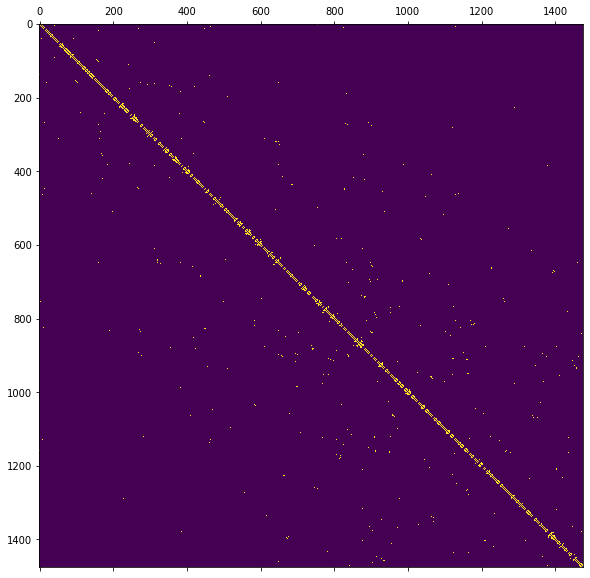

In [22]:
A = emb.graph.adj.A
show(A)

In [23]:
calc_tni(A)

0.9652250829531553

In [24]:
#@title Fit estimation { form-width: "300px" }
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations

def link_eigenvectors_to_coords(vecs, thr_percentile, inds, ms, valid_points, info = 1):
    
    if info:
        print('--------------------------------')
    axis_name_dict = {0:'x', 1:'-x', 2:'y', 3:'-y'}
    crdlist = [ms.scx[inds][valid_points], -ms.scx[inds][valid_points],
               ms.scy[inds][valid_points], -ms.scy[inds][valid_points]]

    right_crd_indices = []

    for i in range(2):
        eigenvector = vecs[i]
        good_points, eigenvector = remove_outliers(eigenvector, thr_percentile)
        
        time = np.arange(len(vecs[i]))[good_points]

        scaler = MinMaxScaler(feature_range=(-1, 1))
        eigenvector = scaler.fit_transform(eigenvector.reshape(-1,1))

        pearson_corr_list = []
        for crd in crdlist:
            crd = scaler.fit_transform(np.array(crd).reshape(-1,1))
            N = len(eigenvector)
            #error = np.round(mae(add_data[good_points], data), 3)
            r, p = scipy.stats.pearsonr(crd[good_points].reshape(N), eigenvector.reshape(N))
            pearson_corr_list.append(r)

        bestcorr = max(pearson_corr_list)
        bestindex = pearson_corr_list.index(bestcorr)
        if info:
            print('eigenvector ' + str(i+1)+ ' stands for', axis_name_dict[bestindex],
                '; correlation = ', np.round(bestcorr, 3))

        if bestcorr < 0.3:
            raise Exception('No good fit found, best correlation', np.round(bestcorr, 2))

        right_crd_indices.append(bestindex)
    
    indset = set(right_crd_indices)
    if indset == {2,3} or indset == {0,1} or len(indset) == 1:
        raise Exception('No good fit found, vectors match the same coordinate')
    
    return [crdlist[i] for i in right_crd_indices]

def estimate_fit(emb, ms, valid_points, i1, i2, thr):
    vecs = [emb.coords.A[i1], emb.coords.A[i2]]
    threshold_percentile = thr
        
    try:
        crd1, crd2 = link_eigenvectors_to_coords(vecs, threshold_percentile, inds, 
                                                 ms, valid_points, info = 0)
        crdlist = crd1, crd2

        r2 = 0
        for i in range(2):
            good_points, eigenvector = remove_outliers(vecs[i], threshold_percentile)

            scaler = MinMaxScaler(feature_range=(-1, 1))
            eigenvector = scaler.fit_transform(eigenvector.reshape(-1,1)).flatten()
            crd = scaler.fit_transform(np.array(crdlist[i]).reshape(-1,1)).flatten()

            r2 += r2_score(crd[good_points], eigenvector)

        r2 = r2/2
    except:
        r2 = 0
        
    #print('R2:', r2)
    return r2

def find_best_embedding_score(N_JUMPS, emb, ms, valid_points, thr, info = 1):

    td = all_embedding_params['target_dim'][N_JUMPS-1]
    combs = list(combinations(range(td), 2))
    res = []
    for pair in combs:
        i1, i2 = pair
        r2 = estimate_fit(emb, ms, valid_points, i1, i2, thr)
        res.append(r2)

    #plt.plot(res)
    if info:
        print('Best embedding:', combs[res.index(max(res))], 'R2 =', max(res))

    if max(res) > 0.1:
        return max(res)
    else:
        return 0

find_best_embedding_score(N_JUMPS, emb, ms, valid_points, 2.5, info = 1)

Best embedding: (0, 1) R2 = 0.644090908517779


0.644090908517779

In [ ]:
#@title Series of experiments { form-width: "300px" }
from IPython.utils import io
from scipy.spatial.distance import pdist, cdist
from scipy.sparse.csgraph import shortest_path
from scipy.stats import pearsonr

PATH = '/content/drive/My Drive/Colab Notebooks/Networks/Mouse results'

def res_var_metric(all_dists, emb_dists):
    m = 1 - (pearsonr(all_dists, emb_dists)[0])**2
    return m

def main(sessions, day, build_spikes, cell_selection_method, frcells, min_spikes, spikes_only,
         std, rebuild_mouse, rebuild_place_cells, rebuild_data,
         all_graph_params, all_embedding_params, denoising_params, enable_denoising = 0, 
         data_compression = 1, tree = None):
    
    with io.capture_output() as captured:

        inds, ms, D = load_mouse_and_data(sessions, day, build_spikes, shuffle_neurodata, cell_selection_method, 
                                            velocity_thr, frcells, min_spikes, spikes_only, std, 
                                            rebuild_mouse, rebuild_place_cells, rebuild_data,
                                            data_compression, tree=tree)

        N_JUMPS = 1
        force_emb_construction = 1
        force_graph_construction = 1

        if enable_denoising:
            wavelet_denoise(D, denoising_params, by_halves = 0, show = 0, std = 1)
        
        emb = jump_series(D, N_JUMPS, all_graph_params, all_embedding_params,
                        efc = force_emb_construction, gfc = force_graph_construction, save = 0)
        
        
        A = emb.graph.adj.A.astype(bool).astype(int)
        si = sausage_index(A, emb.graph.nn)
        valid_points = get_valid_points(emb, D, data_compression) 

        q = find_best_embedding_score(N_JUMPS, emb, ms, valid_points, 2.5, info = 0)
        '''
        #Dmin, Dpr = analyse_graph(D, all_graph_params, mode = 'fast', factor = 1)
        #dim = np.sqrt(Dmin*Dpr)
        g = emb.graph
        dm = g.sqdist_matrix
        dm.data = np.sqrt(g.sqdist_matrix.data)
        spmatrix = shortest_path(dm, method='D', directed=False)
        all_dists = spmatrix.flatten()

        emb_coords = emb.coords.A
        emb_dists = cdist(emb_coords.T, emb_coords.T).flatten()
        m = res_var_metric(all_dists, emb_dists)
        '''
    return q#, si, m


tree = Tree()
tree.load()

sessions = [25]
day = 1
spikes_only = 0

std = 1

cell_selection_method = 'snr_spk'
frcells = 1

velocity_thr = 5
min_spikes = 5
build_spikes = 0
shuffle_neurodata = 0

rebuild_mouse = 0
rebuild_place_cells = 0
rebuild_data = 1
data_compression = 3


inds, ms, D = load_mouse_and_data(sessions, day, build_spikes, shuffle_neurodata, cell_selection_method, 
                                  velocity_thr, frcells, min_spikes, spikes_only, std, 
                                  rebuild_mouse, rebuild_place_cells, rebuild_data,
                                  data_compression, tree=tree)


qualist = []
std_qualist = []


param_name = 'fraction of used cells'
#param_name = 'number of nearest neighbours'

if param_name == 'fraction of used cells':
    n_random = 1
    paramlist = np.linspace(0.04,1,num=20)

elif param_name == 'number of nearest neighbours':
    n_random = 1
    paramlist = [10 + 1*_ for _ in range(20)]


for i in range(len(paramlist)):

    nn = 8
    frcells = 1

    if param_name == 'fraction of used cells':
        frcells = paramlist[i]
    elif param_name == 'number of nearest neighbours':
        nn = paramlist[i]

    print('param =', paramlist[i])

    all_graph_params = {
        'g_method' : ['knn','knn','knn', 'knn'],
        'sigma' : [10, 2, 100, 100],
        'max_deleted_nodes' : [0.1, 0.1, 0.05, 0.05],
        'nn' : [nn, 100, 1000, 200],
        'p' : [2, 2, 2, 2],
        'eps': [2.5, 0, 0, 0],
        'eps_min' : [0, 0, 0, 0]
    }
    
    all_embedding_params = {
        'e_method' : ['isomap','lem','lem','lem'],
        'check_graph_connectivity': [0,0,0,0],
        'target_dim' : [7,5,3,3]
    }
    
    denoising_params = {
        'wavelet': 'haar',
        'thr': None,
        'level': data_compression,
    }

    q_container = []
    
    for j in range(n_random):
        q = main(sessions, day, build_spikes, cell_selection_method, 
                                frcells, min_spikes, spikes_only,
                                std, rebuild_mouse, rebuild_place_cells, rebuild_data,
                                all_graph_params, all_embedding_params, denoising_params, 0, 
                                data_compression = data_compression, tree = tree)
        
        q_container.append(q)


    q = np.mean(q_container)

    if n_random > 1:
        q_std = np.std(q_container)

    else:
        q_std = 0

    qualist.append(q)
    std_qualist.append(q_std)

    #nn = nnlist[i]
    #frcells = 0.9
    

prev_frcells = frcells 
prev_min_spikes = min_spikes
prev_sessions = sessions


In [ ]:
#@title Plot multi experiments { form-width: "300px" }

fig, ax1 = plt.subplots(figsize = (12,10))
ax1.set_xlabel(param_name)
ax1.set_ylabel('best embedding quality')
ax1.plot(paramlist, qualist, c = 'b')
if n_random > 0:
    ax1.errorbar(paramlist, qualist,
                yerr=std_qualist,
                fmt='-o',
                capsize = 5)




In [28]:
#@title 2D hyper-parameter map { form-width: "300px" }
from IPython.utils import io

PATH = '/content/drive/My Drive/Colab Notebooks/Networks/Mouse results'

def main(metric_list, sessions, day, build_spikes, shuffle_neurodata, cell_selection_method,
         velocity_thr, frcells, min_spikes, spikes_only,
         std, rebuild_mouse, rebuild_place_cells, rebuild_data,
         all_graph_params, all_embedding_params, denoising_params, enable_denoising = 0, 
         data_compression = 1, tree = None):
    
    with io.capture_output() as captured:

        inds, ms, D = load_mouse_and_data(sessions, day, build_spikes, shuffle_neurodata,
                                  cell_selection_method, velocity_thr,
                                  frcells, min_spikes, spikes_only, std, 
                                  rebuild_mouse, rebuild_place_cells, rebuild_data,
                                  data_compression, tree=tree)

        N_JUMPS = 1
        force_emb_construction = 1
        force_graph_construction = 1

        if enable_denoising:
            wavelet_denoise(D, denoising_params, by_halves = 0, show = 0, std = 1)
        
        emb = jump_series(D, N_JUMPS, all_graph_params, all_embedding_params,
                        efc = force_emb_construction, gfc = force_graph_construction, save = 0)
        
        
        valid_points = get_valid_points(emb, D, data_compression) 

        res = []
        if 'coord_r2_score' in metric_list:
            q = find_best_embedding_score(N_JUMPS, emb, ms, valid_points, 2.5, info = 0)
            res.append(q)

        if 'tni' in metric_list:
            A = emb.graph.adj.A
            tni = calc_tni(A)
            res.append(tni)

    return np.array(res)


tree = Tree()
tree.load()

sessions = [22]
day = 1
velocity_thr = 5
build_spikes = 0
spikes_only = 0
shuffle_neurodata = 0

min_spikes = 5

std = 1
cell_selection_method = 'snr_spk'
frcells = 1

rebuild_mouse = 0
rebuild_place_cells = 0
rebuild_data = 1
data_compression = 3


inds, ms, D = load_mouse_and_data(sessions, day, build_spikes, shuffle_neurodata,
                                  cell_selection_method, velocity_thr,
                                  frcells, min_spikes, spikes_only, std, 
                                  rebuild_mouse, rebuild_place_cells, rebuild_data,
                                  data_compression, tree=tree)

metric_list = ['coord_r2_score', 'tni']
n_random = 1

xstep = 1
ystep = 0.2
#x = [5+xstep*_ for _ in range(20)]
x = [6+xstep*_ for _ in range(10)]
y = [1+ystep*_ for _ in range(10)]
metric_tensor = np.zeros((len(metric_list), len(x), len(y)))

for cell in tqdm.tqdm(range(len(x)*len(y))):
    i = cell // len(y)
    j = cell % len(y)
        
    data_container = np.zeros((len(metric_list), n_random))

    #print(i*len(y)+j+1, 'points out of', len(x)*len(y))
    p1 = x[i]
    p2 = y[j]

    all_graph_params = {
    'g_method' : ['mink_knn','aknn','knn', 'knn'],
    'sigma' : [10, 10, 100, 100],
    'max_deleted_nodes' : [0.1, 0.1, 0.05, 0.05],
    'alpha': [0, 0, 0, 0],
    'nn' : [p1, 100, 1000, 200],
    'p' : [p2, 2, 2, 2],
    'eps': [2.5, 0, 0, 0],
    'eps_min' : [0, 0, 0, 0]
    }
    
    all_embedding_params = {
        'e_method' : ['isomap','isomap','lem','lem'],
        'check_graph_connectivity': [0,0,0,0],
        'target_dim' : [6,5,3,3],
        'min_dist': [1,1,1,1]
    }
    
    denoising_params = {
        'wavelet': 'haar',
        'thr': None,
        'level': data_compression,
    }

    frcells = 1

    for k in range(n_random):
        res_arr = main(metric_list, sessions, day, build_spikes, shuffle_neurodata, 'snr_spk', 
                        velocity_thr, frcells, min_spikes, spikes_only,
                        std, rebuild_mouse, rebuild_place_cells, rebuild_data,
                        all_graph_params, all_embedding_params, denoising_params,
                        enable_denoising = 0, 
                        data_compression = data_compression, tree = tree)
        try:
            pass

        except:
            q = 0
            t = 0

        #print(data_container[:,k])
        #print(res_arr)
        data_container[:,k] = res_arr

    metric_tensor[:,i,j] = np.mean(data_container, axis = 1)

Creating data...



100%|██████████| 100/100 [1:38:48<00:00, 59.28s/it]


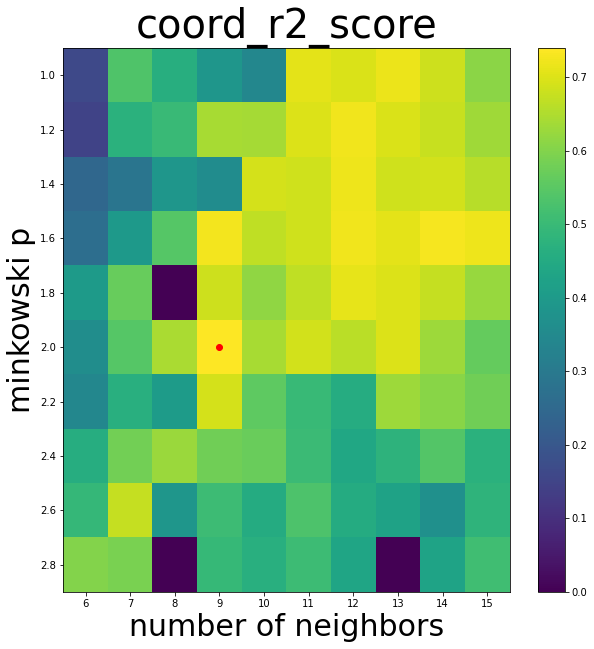

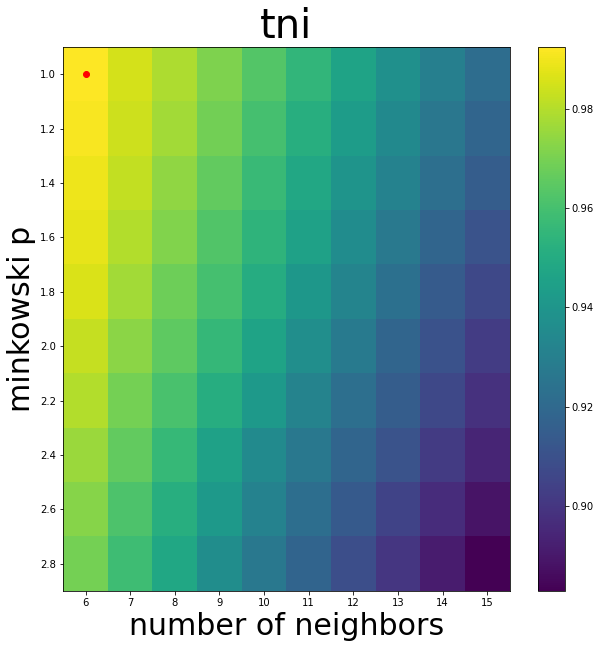

In [30]:
#@title 2D hyper-parameter visualization { form-width: "300px" }
import matplotlib.pyplot as plt

for i, metric in enumerate(metric_tensor):

    fig, ax = plt.subplots(figsize = (len(x), len(y)))
    extent = np.min(x)-0.5*xstep, np.max(x)+0.5*xstep, np.max(y)+0.5*ystep, np.min(y)-0.5*ystep

    qmat = metric_tensor[i]
    im = ax.imshow(qmat.T, extent = extent, aspect = 'auto')
    ax.set_title(metric_list[i], fontsize = 40)
    #ax.set_ylabel('sigma')
    ax.set_ylabel('minkowski p', fontsize = 30)
    #ax.set_xlabel('number of neighbours')
    ax.set_xlabel('number of neighbors', fontsize = 30)
    ax.set_xticks(x)
    ax.set_yticks(y)

    maxind = np.unravel_index(qmat.T.argmax(), qmat.T.shape)
    #print(maxind)
    #print(x[maxind[1]], y[maxind[0]])
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    ax.scatter(x[maxind[1]], y[maxind[0]], c='r')

#print(qmat.T)

In [ ]:
qlist = []
thrlist = np.linspace(1,3,10)
for thr in thrlist:
    q = find_best_embedding_score(emb, ms, thr, info = 1)
    qlist.append(q)

fig, ax = plt.subplots(figsize = (12,16))
ax.plot(thrlist, qlist)

In [ ]:
emb.draw_eigenvectors(0, 8, ms.scx[inds][valid_points], ms.scy[inds][valid_points])

In [ ]:
g = nx.from_numpy_array(emb.graph.adj.A)
print(sum((nx.triangles(g)).values()))
#print(list(g.nodes()))
#H = nx.subgraph(g, range(0,6000))
#nx.draw(H, node_size = 1)

In [ ]:
print(emb.coords.A)

[[-2.21247639e+00  1.20651415e+00  5.22402029e-01 -1.46431612e+00
   8.16477893e-01  1.02198623e+00]
 [-1.39698018e+00  1.54945246e+00 -1.44024090e-03 -1.42165500e+00
   8.35278824e-01  8.51079090e-01]
 [-1.43375688e+00  1.55865231e+00  1.48092520e-02 -1.46978620e+00
   8.64880179e-01  8.65702528e-01]
 ...
 [ 3.39045691e+00 -7.38869842e-01  1.26464510e+00 -4.31872511e-01
  -1.24035293e+00  4.24537295e-01]
 [ 3.25714164e+00 -1.24081857e+00  9.22916097e-01  6.92715841e-02
  -1.47945575e+00 -8.07964149e-01]
 [ 3.37082990e+00 -7.59682924e-01  1.27043888e+00 -4.28137303e-01
  -1.23466152e+00  4.15433590e-01]]


'\nfor x in [0.56, 0.37, 0.76]:\n    plt.axvline(x)\nfor y in [0.75, 0.38, 0.38]:\n    plt.axhline(y)\n'

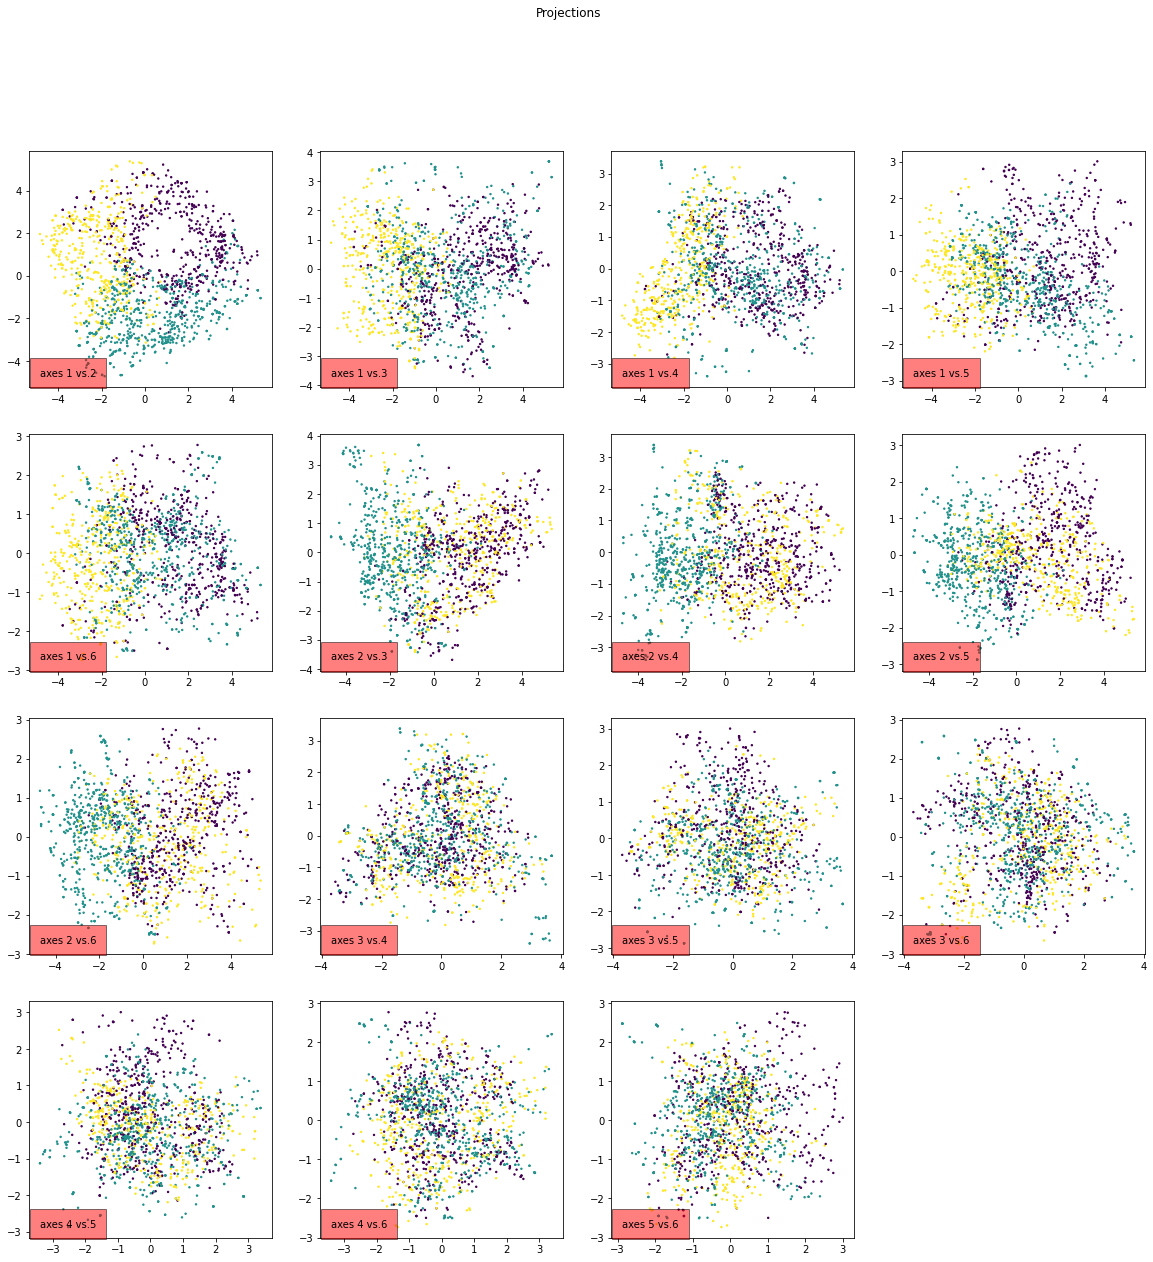

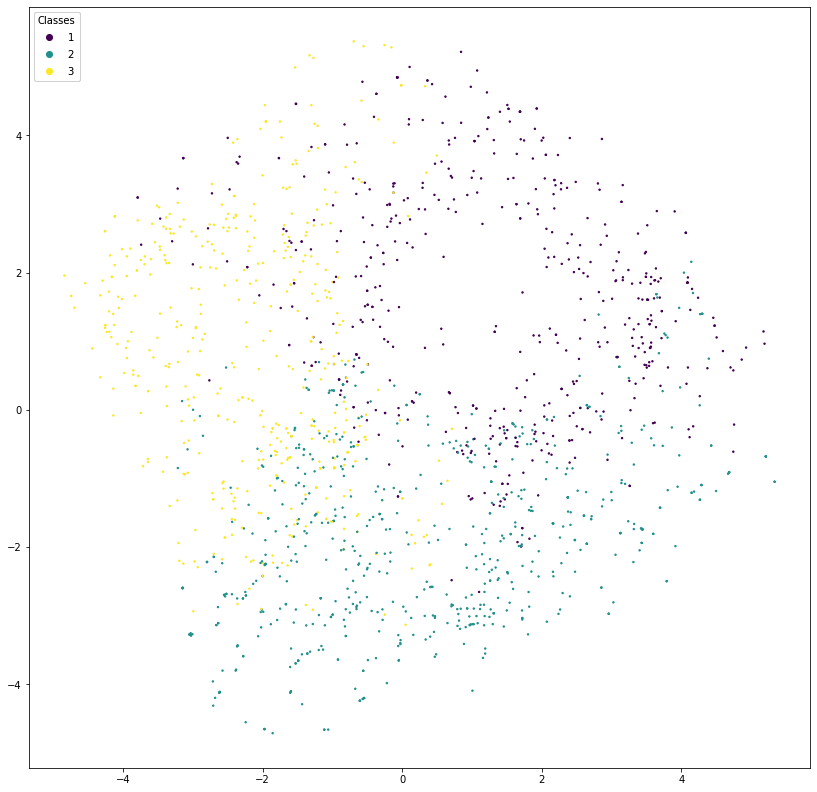

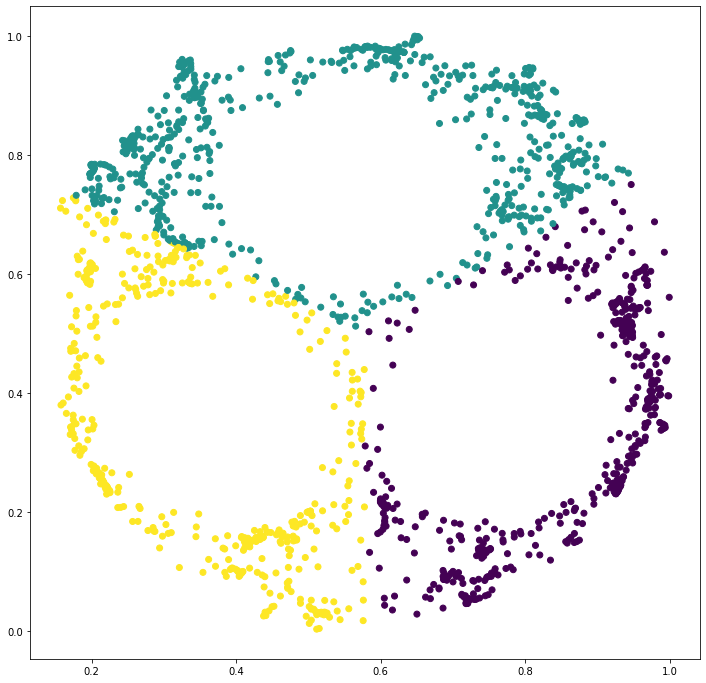

In [42]:
#@title Fast plotting { form-width: "300px" }
#vels = rescale(smooth(get_track_velocities_from_coords(session, day, thr = thr, mode = 'abs'), 200))
#vels = get_track_velocities_from_coords(session, day, thr = thr, mode = 'abs')
#colors = velocity_filter(session, day, vels, thr, vel_sigma_thr)
#colors = get_track_angles(session, day, thr = 1000)[valid_points]
#colors = np.array(range(emb.graph.data.shape[1]))[valid_points]
#inds = range(emb.graph.data.shape[1])
ms.get_angle()
#ms.get_acceleration()
#modified_speed = [s for s in list(ms.speed)+[ms.speed[-1]]]

r_from_center = get_r_from_center(ms)
domains = get_domains(ms, circle_mode = 0)
timeline = np.array(range(ms.n_frames))

#colors = ms.angle[inds][valid_points]
colors = domains[inds][valid_points]
#colors = np.sign(ms.vy)[inds][valid_points]
#colors = ms.acceleration[inds][valid_points]
#colors = timeline[inds][valid_points]
#colors = r_from_center[inds][valid_points]
#print(len(colors))
emb.plot_all(colors, thr_percentile = 2.5, legend = 0)

i = 0
emb.plot_2d(colors, i, i+1, thr_percentile = 2.5)
ms.trajectory(points = inds[valid_points], colors = colors)
'''
for x in [0.56, 0.37, 0.76]:
    plt.axvline(x)
for y in [0.75, 0.38, 0.38]:
    plt.axhline(y)
'''
#emb.plot_timeline(3, colors, add_data = vels)


In [ ]:
#@title Routines { form-width: "300px" }
def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """

    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

def softmax(X, diag_zero=True):
    """Take softmax of each row of matrix X."""

    # Subtract max for numerical stability
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    # We usually want diagonal probailities to be 0.
    if diag_zero:
        np.fill_diagonal(e_x, 0.)

    # Add a tiny constant for stability of log we take later
    e_x = e_x + 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

def calc_prob_matrix(distances, sigmas=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)

def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, 
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess

def calc_perplexity(prob_matrix):
    """Calculate the perplexity of each row 
    of a matrix of probabilities."""
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas):
    """Wrapper function for quick calculation of 
    perplexity over a distance matrix."""
    return calc_perplexity(calc_prob_matrix(distances, sigmas))


def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

def q_joint(Y):
    """Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    # Get the distances from every point to every other
    distances = neg_squared_euc_dists(Y)
    # Take the elementwise exponent
    exp_distances = np.exp(distances)
    # Fill diagonal with zeroes so q_ii = 0
    np.fill_diagonal(exp_distances, 0.)
    # Divide by the sum of the entire exponentiated matrix
    return exp_distances / np.sum(exp_distances), None


def p_conditional_to_joint(P):
    """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
    return (P + P.T) / (2. * P.shape[0])

def joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P

In [ ]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def change_labels_color(ax):
    [t.set_color('white') for t in ax.xaxis.get_ticklines()]
    [t.set_color('white') for t in ax.xaxis.get_ticklabels()]
    [t.set_color('white') for t in ax.yaxis.get_ticklines()]
    [t.set_color('white') for t in ax.yaxis.get_ticklabels()]


PERPLEXITY = 20
perplist = [5,10,20,50,100,200]
dimlist = range(1,15)
kldmat = np.zeros((len(perplist), len(dimlist)))

N = 1000
#X = hypercube(N, 5)
#X = swiss_roll(N, 0.0, tree = None, std = 0)
#X = hypershere_surface(N, 5)
#X = mnist(nsamples = N)
X = D.data.A
print(X.shape)

for i in range(len(perplist)):
    perp = perplist[i]
    print('perp=', perp)
    p = joint(X.T, perp)

    
    for j in range(len(dimlist)):
        d = dimlist[j]
        #print('dim =', d)
        
        #Y = create_auto_lem_embedding(X, PERPLEXITY, d)
        Y = spectral_embedding(p, n_components=d, eigen_solver=None, 
                                random_state=None, eigen_tol=0.0,
                                norm_laplacian=True, drop_first=True).T

        q = joint(Y.T, perp)
        kld = entropy(p.ravel(), qk = q.ravel())
        kldmat[i,j] = kld

(381, 1138)
perp= 5
perp= 10
perp= 20
perp= 50
perp= 100
perp= 200


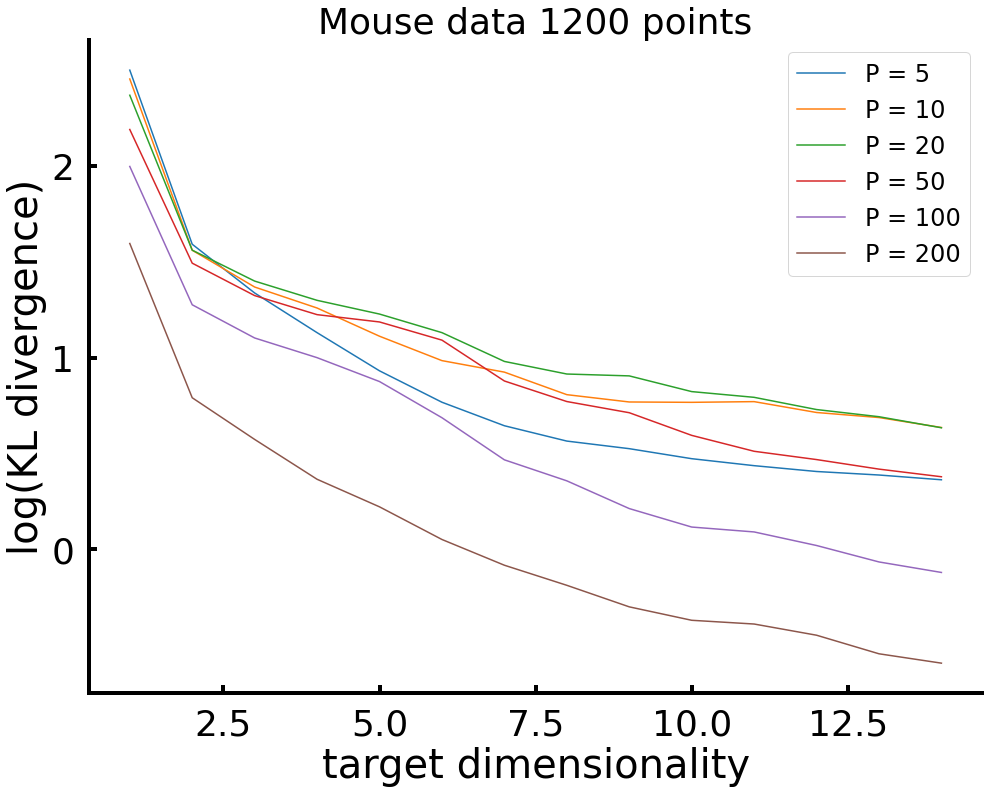

In [ ]:
fig, ax = plt.subplots(figsize = (16,12))
ax.set_xlabel('target dimensionality', fontsize = 40)
ax.set_ylabel('log(KL divergence)', fontsize = 40)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)
    ax.tick_params(width=4, direction = 'in', length = 8, pad=15)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.setp(ax.get_xticklabels(), fontsize=36)
plt.setp(ax.get_yticklabels(), fontsize=36)

for i in range(len(perplist)):
    perp = perplist[i]
    ax.plot(dimlist, np.log(kldmat[i]), label = 'P = '+str(perp))

ax.set_title('Mouse data 1200 points', fontsize=36)
ax.legend(fontsize = 24)

In [ ]:
fig, ax = plt.subplots(figsize = (16,16))
ax.matshow(emb.graph.adj.A.astype(int))
'''
fig, ax2 = plt.subplots(figsize = (16,16))
ax2.matshow(gt.astype(int))
'''

In [ ]:
#@title Latent space plotting { form-width: "300px" }
import scipy.stats as st

def prepare_figure(dim = 2):
    fig = plt.figure(figsize=(15, 10))
    proj = '3d' if dim == 3 else None
    ax = plt.axes(projection=proj)
    change_labels_color(ax)
    ax.set_xlabel('real')
    ax.set_ylabel('imag')
    if dim == 3:
        ax.set_zlabel('PDF')
        ax.set_title('Surface plot of Gaussian 2D KDE', c = 'w')
    else:
        ax.set_title('2D Gaussian Kernel density estimation')

    return fig, ax

def prepare_grid(x,y):
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return (xmin, xmax, ymin, ymax, xx, yy, f)
    
def plot_2d_density_distr(x, y, ax = None):

    (xmin, xmax, ymin, ymax, xx, yy, f) = prepare_grid(x,y)
    #ax.set_xlim(xmin, xmax)
    #ax.set_ylim(ymin, ymax)
    if ax is None:
        fig, ax = prepare_figure(dim = 2)
        
    #ax.title.set_color('white')

    cfset = ax.contourf(xx, yy, f, levels = 50, cmap='coolwarm')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
    cset = ax.contour(xx, yy, f, colors='k')
    ax.clabel(cset, inline=1, fontsize=10)

def density_plot():
    ind = 6000
    fig = plt.figure(figsize = (16,8))
    fig.suptitle('Trajectory vs first two components')

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('LE comp1-comp2')
    #ax1.set_xlim(left = min(emb.coords.A[0]), right = max(emb.coords.A[0]))
    #ax1.set_ylim(bottom = min(emb.coords.A[1]), top = max(emb.coords.A[1]))

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('Mouse 22_1 trajectory')
    plot_2d_density_distr(emb.coords.A[0][:ind], emb.coords.A[1][:ind], ax = ax1)
    plot_2d_density_distr(-ms.scy[:ind], -ms.scx[:ind], ax = ax2)

def plot_emb_components(emb, thr, add_data, add_data_thr = 100, excluded = []):
    emb.coords = sp.csr_matrix(emb.coords)
    colors = np.zeros(emb.coords.shape[1])
    nplots = emb.coords.shape[0]
    fig, axs = plt.subplots(nplots, figsize = (16,12))
    fig.suptitle('Latent space components')
    for i in range(nplots):
        if i not in excluded:
            emb.plot_timeline(i, thr, colors, fig = 1, cmap = None,
                        add_data = add_data, add_data_thr = add_data_thr, ax = axs[i])
    
    plt.show()

p= 7.119569566439841e-21
p= 1.0596694205515598e-53
p= 5.977937352951942e-129
p= 1.4034098842858054e-238
p= 1.3676088517530237e-81
p= 0.0


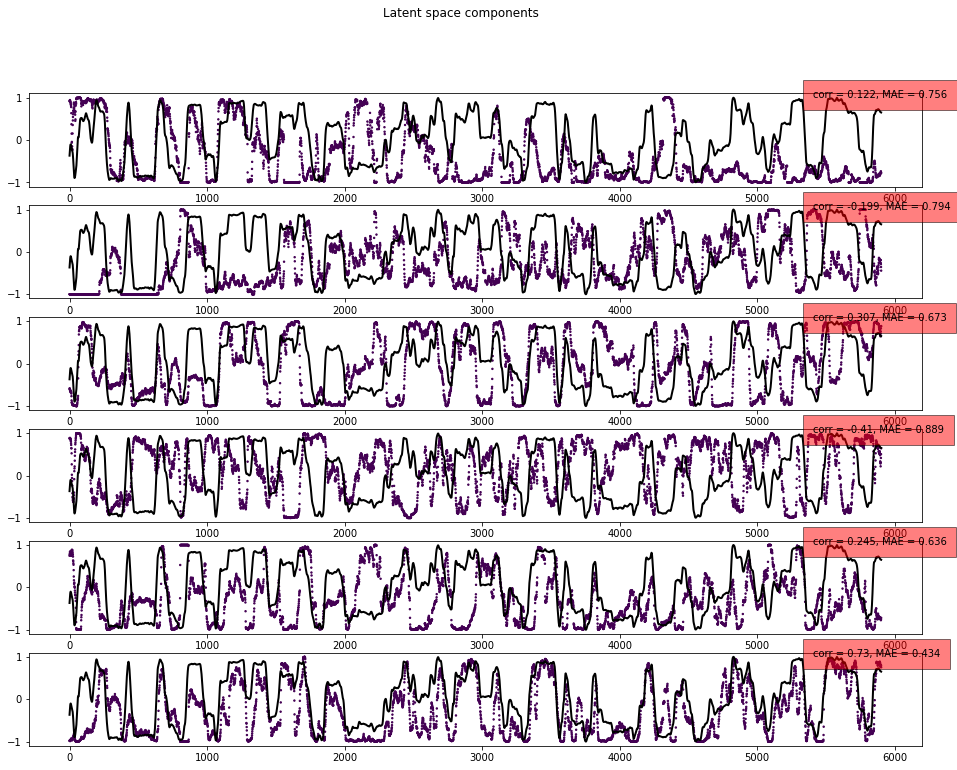

In [ ]:
theta = 0

th = theta/360*2*np.pi
xd = ms.x[inds][valid_points]
yd = ms.y[inds][valid_points]
vxd = ms.vx[inds][valid_points]
vyd = ms.vy[inds][valid_points]
vd = ms.v[inds][valid_points]
gp1, vxd = remove_outliers(vxd, 3)
gp2, vyd = remove_outliers(vyd, 3)
gp = [p for p in range(len(vxd)) if p in gp1 and p in gp2]
add_data = xd*np.cos(th) - yd*np.sin(th)
#add_data = vxd[gp]*np.cos(th) - vyd[gp]*np.sin(th)
#add_data = vd[gp]

excluded = []
plot_emb_components(emb, 2.5, excluded = excluded, add_data = add_data, add_data_thr = 3)

In [ ]:
#@title Make GIF { form-width: "300px" }
import tqdm
import imageio
from os import listdir, remove
from os.path import isfile, join
from IPython.utils import io
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt


PATH = '/content/drive/My Drive/Colab Notebooks/Networks/Mouse results/For GIFs'

def destroy_previous():
    # destroy all previous images
    all_prev_files = [f for f in listdir(PATH) if isfile(join(PATH, f))]
    for f in all_prev_files:
        remove(join(PATH,f))


def create_image_series(n_images, points_in_step, emb, vecs, colors, crd1, crd2):
    #with io.capture_output() as captured:

    psize = 1.2
    vec1, vec2 = vecs
    for i in tqdm.tqdm(range(1, n_images), leave = True, position = 0):
        fig = plt.figure(figsize = (16,8))
        fig.suptitle('Trajectory vs first two components')

        ax1 = fig.add_subplot(1, 2, 1)
        ax1.set_title('LE comp1-comp2')
        #ax1.set_xlim(left = min(emb.coords.A[0]), right = max(emb.coords.A[0]))
        #ax1.set_ylim(bottom = min(emb.coords.A[1]), top = max(emb.coords.A[1]))

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.set_title('Mouse '+str(ms.session)+'_'+str(ms.day)+' trajectory')
        #ax2.set_xlim(left = min(-ms.scy), right = max(-ms.scy))
        #ax2.set_ylim(bottom = min(-ms.scx), top = max(-ms.scx))

        ind = i*points_in_step
        ax1.scatter(vec1[:ind], vec2[:ind], c = colors[:ind], s=psize)
        ax2.scatter(crd1[:ind], crd2[:ind], c = colors[:ind], s=psize)
        nn = emb.graph.nn
        ncells = emb.graph.data.shape[0]
        plt.savefig(join(PATH, str(i)+ '_cells=' + str(ncells)+' n='+str(len(vec1))+' nn='+ str(nn)))
        plt.close()

def dynamic_correlation(vecs, crd1, crd2):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    fig, ax = plt.subplots(figsize = (16,8))

    vec1, vec2 = vecs
    crd1 = scaler.fit_transform(np.array(crd1).reshape(-1,1))
    crd2 = scaler.fit_transform(np.array(crd2).reshape(-1,1))
    vec1 = scaler.fit_transform(np.array(vec1).reshape(-1,1))
    vec2 = scaler.fit_transform(np.array(vec2).reshape(-1,1))

    corr = signal.correlate(vec1, crd1)/len(vec1)
    ax.plot(corr)
    #corr2 = signal.correlate(vec2, crd2)/len(vec2)
    #plt.plot(corr2)

def eigenvector_coord_synchrony(emb, vecs, crd1, crd2, ax = None):
    scaler = MinMaxScaler(feature_range=(-1, 1))

    vec1, vec2 = vecs
    crd1 = scaler.fit_transform(np.array(crd1).reshape(-1,1)).reshape(1,-1)[0]
    crd2 = scaler.fit_transform(np.array(crd2).reshape(-1,1))
    vec1 = scaler.fit_transform(np.array(vec1).reshape(-1,1)).reshape(1,-1)[0]
    vec2 = scaler.fit_transform(np.array(vec2).reshape(-1,1))

    scaler = MinMaxScaler(feature_range=(0, 1))
    speed = scaler.fit_transform(ms.v.reshape(-1,1))

    al1 = np.angle(hilbert(vec1),deg=False)
    al2 = np.angle(hilbert(crd1),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    print(phase_synchrony)

    if ax == None:
        fig, ax = plt.subplots(figsize = (20,10))

    #ax.plot(phase_synchrony)
    emb.plot_timeline(i1, threshold_percentile, colors, add_data = crd1[valid_points], ax = ax)
    #emb.plot_timeline(i2, threshold_percentile, colors, add_data = crd2[valid_points], ax = ax)
    #plt.plot(speed, c = 'r')

def create_gif():
    destroy_previous()
    create_image_series(400, 20, emb, vecs, colors, crd1, crd2)

    images = []
    files = [f for f in listdir(PATH) if isfile(join(PATH, f)) \
            and str(len(emb.coords.A[0])) in f and ' nn='+ str(emb.graph.nn) in f\
            and str(D.data.shape[0]) in f]

    sorted(files)
    for filename in tqdm.tqdm(files, leave = True, position = 0):
        images.append(imageio.imread(join(PATH, filename)))

    imageio.mimsave(join(PATH, 'GIFs', 'cells=' + str(emb.graph.data.shape[0])+
                    ' points='+str(len(vecs[0]))+' nn='+ str(emb.graph.nn)+ ' trajectory vs 0-1 components.gif'),
                    images, duration=0.2)


i1, i2 = 0,1
vecs = [emb.coords.A[i1], emb.coords.A[i2]]
threshold_percentile = 2.5

'''
fig, ax = plt.subplots(figsize = (16,8))
good_points, speed = remove_outliers(ms.speed[inds], threshold_percentile)
scaler = MinMaxScaler(feature_range=(0, 1))
speed = scaler.fit_transform(speed.reshape(-1,1))
ax.plot(speed[1000:6000])
'''
crd1, crd2 = link_eigenvectors_to_coords(vecs, threshold_percentile, inds, ms)
eigenvector_coord_synchrony(emb, vecs, crd1, crd2)

#dynamic_correlation(vecs, crd1, crd2)
#create_gif()

In [ ]:
i1, i2 = 0,1
vecs = [emb.coords.A[i1], emb.coords.A[i2]]
threshold_percentile = 100
crd1, crd2 = link_eigenvectors_to_coords(vecs, threshold_percentile, inds, ms)

emb.plot_timeline(i1, threshold_percentile, colors, add_data = crd1[valid_points])
emb.plot_timeline(i2, threshold_percentile, colors, add_data = crd2[valid_points])
#emb.plot_timeline(2, colors, add_data=-0.5*(ms.scy+1))

In [ ]:
#@title Neuron correlations { form-width: "300px" }
import scipy.stats as st

def plot_mat(mat):
    fig, ax = plt.subplots(figsize = (12, 12))
    change_labels_color(ax)
    im = ax.imshow(mat)
    cbar = ax.figure.colorbar(im, ax=ax)

def correlation_matrix(a, b):   
    n1 = a.shape[0]
    n2 = b.shape[0]
    corrmat = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            corrmat[i,j] = np.abs(st.pearsonr(a[i,:], b[j,:])[0])

    return corrmat

w = 500
s = 500
for i in range(10):
    C = correlation_matrix(D.data.A[:,s*i:s*i+w], D.data.A[:,s*i:s*i+w])
    plot_mat(C)

In [ ]:
#@title Mechanical mouse { form-width: "300px" }


# Postprocessing & analysis


In [ ]:
!pip install circle-fit

In [ ]:
#@title Neurodata analysis { form-width: "300px" }

rpath = '/content/drive/My Drive/Colab Notebooks/DataRoot/Our filtered data/Rears'
rname  = 'CA1_22_1D_rears_from_npz.csv'


scx, scy = get_scaled_coords(session, day, thr = 2000, r_angle = 0)
scvabs, scvx, scvy = get_scaled_velocities(session, day, thr = 2000)
'''
aver_window = 200
aver_scvabs = uniform_filter1d(scvabs, size = aver_window)
aver_scvabs = scaler.fit_transform(aver_scvabs.reshape(-1,1)).ravel()
aver_scvx = uniform_filter1d(scvx, size = aver_window)
aver_scvx = scaler.fit_transform(aver_scvx.reshape(-1,1)).ravel()
aver_scvy = uniform_filter1d(scvy, size = aver_window)
aver_scvy = scaler.fit_transform(aver_scvy.reshape(-1,1)).ravel()
r = pd.read_csv(os.path.join(rpath, rname))
#plt.figure(figsize=(15,10))
'''

vals = get_track_velocities_from_coords(session, day, thr = 2000, mode = 'abs')
#vals = get_track_accelerations(thr = 2000)
'''
print('real:')
print(np.round(vals, 4)[:20])

min_error, computed = find_best_angles(vals, emb)
print('rmse:', np.sqrt(min_error))
'''

best = find_best_rotation(session, day, emb, 3, direction = 'y', mode = 'vel', thr = 2000)
#vals = computed

#vals = range(emb.coords.shape[1])

#colors = get_track_angles(thr = 2000)

#colors = get_track_velocities(thr = 2000, mode = 'x')
#emb.plot_timeline(3, colors, add_data = aver_scvabs)

emb.plot_timeline(3, colors, add_data = best)
#emb.plot_timeline(3, colors, add_data = scvabs)
#bestrotscvx, bestrotscvy = get_scaled_coords(thr = 2000, r_angle = best_angle)
#emb.plot_timeline(3, colors, add_data = bestrotscvx)
#emb.plot(colors = vals)


In [ ]:
#@title Scaling { form-width: "300px" }
'''
diagdens = emb.graph.scaling()
#print(diagdens)
ind = 100

hist = np.histogram(np.array(diagdens[ind:]), bins = 100)
vals = hist[0]+1

fig, ax = plt.subplots(figsize = (16,12))
change_labels_color(ax)

x = np.log10(range(1,len(vals)))
ax.scatter(x, np.log10(vals)[1:])
#ax.plot(x, -x+7)
#np.log10(range(emb.coords.shape[1]))[ind+1:]
#ax.hist(np.array(diagdens[ind:]), bins = 150, log = 1)
'''

from math import sqrt
import numpy as np

def generate_bins(N, start=4, bins_per_order_magn=25):
    lstart = np.log10(start)
    lend = np.log10(N - 1) + 1e-6
    num = int(np.ceil((lend - lstart) * bins_per_order_magn))
    bins = np.unique(np.logspace(lstart, lend, dtype=int, num=max(num, 0)))
    if len(bins) > 0:
        assert bins[-1] == N - 1
    return bins
	
def compute_scaling(a):
	# computes scaling in the matrix $a$ for logariphmically spaced bins
	
	N = len(a)
	bins0 = generate_bins(N)

	# lengths of all contacts in the matrix
	inds_nonzero = np.nonzero(a)
	len_contacts = np.abs(inds_nonzero[1]-inds_nonzero[0])

	# computes the number of contacts in bins
	scontacts = np.sort(len_contacts)
	connumbers = np.diff(np.searchsorted(scontacts, bins0, side="left"))

	# area of the bins
	possible = np.diff(N * bins0 + 0.5 * bins0 - 0.5 * (bins0 ** 2))

	scaling = connumbers / possible
	bins = [(bins0[i], bins0[i + 1]) for i in range(len(bins0) - 1)]
	new_bins = [sqrt(i[0] * (i[1] - 1)) for i in bins]

	return new_bins, scaling



A = emb.graph.adj.A
new_bins, scaling = compute_scaling(A)

fig, ax = plt.subplots(figsize = (16,10))
ax.set_xlabel('log(bin_number)')
ax.set_ylabel('log(scaling)')

logx = np.log(new_bins)
logs = np.log(scaling)
border1 = 0.0
border2 = 0.2
b1, b2 = int(border1*len(logx)), int(border2*len(logx))
z = np.polyfit(logx[b1:b2], logs[b1:b2], 1)


ax.plot(logx, logs)
ax.plot(logx[b1:b2], z[0]*logx[b1:b2]+z[1])
text = 'slope = ' + str(np.round(z[0], 2))
ax.text(5, -3, text, fontsize = 20)

In [ ]:
plt.plot(ms.v)

In [ ]:
#@title Outlier detection { form-width: "300px" }
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
#X = [[-1.1], [0.2], [101.1], [0.3]]
X = emb.coords.A[0].reshape(-1, 1)
clf = LocalOutlierFactor(n_neighbors=5)
clf.fit_predict(X)

nof = clf.negative_outlier_factor_
out_thr = np.percentile(nof, 5)
print(out_thr)
outliers = np.where(nof<-100)[0]
print(len(outliers)/len(X))

In [ ]:
#@title Automatic embedding detection { form-width: "300px" }
emb.calculate_ipr()
ee = emb.erdos_entropy
#plt.plot(ee)
#i1 = np.where(ee == max(ee))[0]
#mod_ee = ee[np.arange(len(ee))!=i1]
#i2 = np.where(mod_ee == max(mod_ee))[0]
#print(i1, i2)
alpha = 2
asymlist = []
for i in range(all_embedding_params['target_dim'][0]):
    crd = emb.coords.A[i]
    #print('eigenvector', i)
    positive = crd[np.where(crd>0)[0]]
    negative = crd[np.where(crd<0)[0]]
    ps = sum([x**alpha for x in positive])
    ns = sum([x**alpha for x in negative])
    asymmetry = np.round((ps - ns)**2/(ps+ns)**2, 6)
    #print('asymmetry =', asymmetry)
    asymlist.append(np.log10(asymmetry))

plt.plot(asymlist)

In [ ]:
#@title Min sigma { form-width: "300px" }
sessions = [25]
day = 1
build_spikes = 0
spikes_only = 0

min_spikes = 5

inds, ms, D = load_mouse_and_data(sessions, day, build_spikes, frcells, min_spikes, spikes_only, std, 
                                rebuild_mouse, rebuild_place_cells, rebuild_data, tree=tree)

min_sigma_list = []
for i in range(len(frcells_list)):
    frcells = frcells_list[i]
    cells_with_enough_spikes = np.where(ms.spikes_count > min_spikes)[0]
    candidate_z_scores = ms.cell_z_score[cells_with_enough_spikes]
    good_cell_inds = np.argsort(candidate_z_scores)[-int(frcells*len(candidate_z_scores)):]
    min_sigma = candidate_z_scores[good_cell_inds[0]]
    min_sigma_list.append(min_sigma)

fig, ax = plt.subplots(figsize = (12,10))
ax.set_xlabel('fraction of used cells')
ax.set_ylabel('min sigma level')
ax.plot(frcells_list, min_sigma_list, c = 'b')

# Tech routines



In [ ]:
#@title Pickling { form-width: "300px" }
import pickle
from os.path import join

PATH = '/content/drive/My Drive/Colab Notebooks/DataRoot/Neurodata_holes//'
#create a pickle file
picklefile = open(join(PATH,ms.name), 'wb')
#pickle the dictionary and write it to file
pickle.dump(ms, picklefile)
#close the file
picklefile.close()

In [ ]:
#@title Unpickling { form-width: "300px" }

session = 22
day = 1
name = 'CA1_'+str(session)+'_HT'+str(day)

#read the pickle file
picklefile = open(join(PATH,name), 'rb')
#unpickle the dataframe
ms2 = pickle.load(picklefile)
#close file
picklefile.close()